In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from glob import glob
import numpy as np
from tqdm import tqdm

import networkx as nx
import networkx_temporal as tx
import nltk

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
# Data paths
n9_path = 'D:/FV/Personal/VIU/clean_data/9n_9ngranmarchaporlajusticia.csv'
noAlTar_path = 'D:/FV/Personal/VIU/clean_data/noaltarifazo_ruidazonacional.csv'

In [3]:
# Load and Clean data
noAlTar_df = pd.read_csv(noAlTar_path)
noAlTar_df['date'] =pd.to_datetime( noAlTar_df.hour * 3600, unit='s')
noAlTar_df['hashtag'] = noAlTar_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')

n9_df = pd.read_csv(n9_path)
n9_df['date'] =pd.to_datetime(n9_df.hour * 3600, unit='s')
n9_df['hashtag'] = n9_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')



In [4]:

from sklearn.preprocessing import LabelEncoder
noAltar_hash_encoder = LabelEncoder()
noAltar_hash_encoder.fit(noAlTar_df.hashtag.unique())

noAltar_user_encoder = LabelEncoder()
noAltar_user_encoder.fit(noAlTar_df.user.unique())

n9_hash_encoder = LabelEncoder()
n9_hash_encoder.fit(n9_df.hashtag.unique())

n9_user_encoder = LabelEncoder()
n9_user_encoder.fit(n9_df.user.unique())


LabelEncoder()

In [171]:
str_identifier = 'hashNodes'
# str_identifier = 'userNodes'
# str_identifier = 'bipartite'

comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/comp_metrics_{}.pickle'.format(str_identifier)

with open(comp_metrics_path, 'rb') as handle:
    comp_metrics = pickle.load(handle)

comp_metrics_9n = comp_metrics['9n']

giant_comp_per_hour_9n = {key:sorted(comp_metrics_9n[key]['components'][0]) for key in comp_metrics_9n.keys()}

giant_comp_per_hour_9n

hours_9n = sorted(giant_comp_per_hour_9n.keys())

leven_distance = np.full((len(hours_9n), len(hours_9n)), np.nan)

for i in tqdm(range(len(hours_9n))):
    for j in range(len(hours_9n)):
        if i > j:
            leven_distance[i,j] = nltk.edit_distance(giant_comp_per_hour_9n[hours_9n[i]], giant_comp_per_hour_9n[hours_9n[j]])

 35%|███▌      | 34/97 [02:07<03:56,  3.75s/it]


KeyboardInterrupt: 

# Similarity of the giant compenent using Levenshtein Distance

In [178]:

def plot_Levenshtein_Distance(df, critical_time, period_start , date_step = 8):

    critical_dist_df = pd.concat([df[df.index == critical_time].dropna(axis=1), 
                                df.T[df.T.index == critical_time].dropna(axis=1)], axis=1).T
    min_dist  = critical_dist_df.min().values[0]

    critical_dist_df.loc[critical_time,:] = 0
    critical_dist_df.sort_index(inplace = True)

    critical_dist_df.reset_index(inplace = True)
    critical_dist_df.columns = ['date', 'Edit dist. to GC\nin critical point']

    fig, axes = plt.subplots(1,1, figsize = [10, 4],sharex=True)

    sns.lineplot(data = critical_dist_df, x = 'date', y = 'Edit dist. to GC\nin critical point', ax = axes)

    y_lims = axes.get_ylim()


    axes.set_ylim([min_dist - min_dist*.1, y_lims[1]])

    # Set the major ticks at intervals, e.g., every 5th tick
    axes.set_xticks(axes.get_xticks()[::date_step])

    axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode='anchor')

    axes.axvline(critical_time, color = 'red')
    axes.axvspan(critical_dist_df.date.min(), period_start, facecolor='cadetblue', alpha=0.5)
    axes.axvspan(period_start, critical_dist_df.date.max(), facecolor='lightsalmon', alpha=0.5)
    axes.set_xlim([critical_dist_df.date.min(), critical_dist_df.date.max() ]);



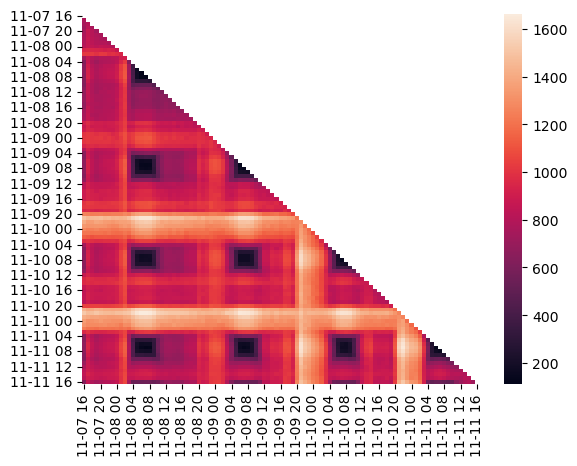

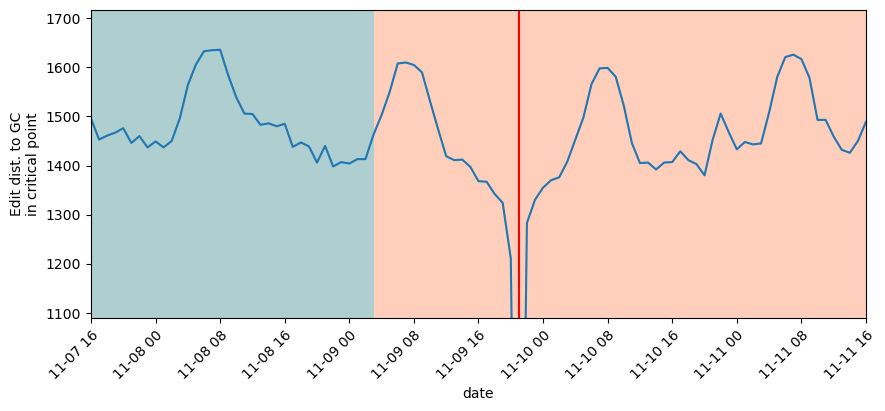

In [196]:
# distances_path = 'D:/FV/Personal/VIU/clean_data/giantComp_levenshtein_distance_userNodes.pickle'
distances_path = 'D:/FV/Personal/VIU/clean_data/giantComp_levenshtein_distance_bipartite.pickle'

with open(distances_path, 'rb') as handle:
    distances = pickle.load(handle)



leven_distance_9n_df = distances['9n'].copy()
leven_distance_9n_df.index = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_9n_df.index]
leven_distance_9n_df.columns = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_9n_df.columns]
import seaborn as sns

leven_distance_9n_df = (leven_distance_9n_df) 

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(leven_distance_9n_df)

sns.heatmap(leven_distance_9n_df, mask=matrix)

critical_time = '11-09 21'
period_start = '11-09 03'

plot_Levenshtein_Distance(leven_distance_9n_df, critical_time, period_start)

In [183]:
distances.keys()

dict_keys(['9n', 'no'])

In [189]:
distances['no']

11-07 16  11-07 17  11-07 18  11-07 19  11-07 20  11-07 21  \
11-07 16       NaN     654.0     642.0     606.0     616.0     636.0   
11-07 17     654.0       NaN     690.0     706.0     721.0     721.0   
11-07 18     642.0     690.0       NaN     647.0     679.0     681.0   
11-07 19     606.0     706.0     647.0       NaN     624.0     651.0   
11-07 20     616.0     721.0     679.0     624.0       NaN     622.0   
...            ...       ...       ...       ...       ...       ...   
11-11 12     611.0     702.0     680.0     651.0     639.0     651.0   
11-11 13     675.0     729.0     706.0     684.0     681.0     694.0   
11-11 14     699.0     753.0     727.0     714.0     705.0     720.0   
11-11 15     649.0     713.0     684.0     677.0     661.0     676.0   
11-11 16     494.0     689.0     657.0     609.0     614.0     637.0   

          11-07 22  11-07 23  11-08 00  11-08 01  ...  11-11 07  11-11 08  \
11-07 16     644.0     653.0     684.0     790.0  ...     532.0     533.0   
11-07 17     724.0     713.0     731.0     804.0  ...     769.0     757.0   
11-07 18     688.0     688.0     722.0     792.0  ...     711.0     704.0   
11-07 19     674.0     672.0     698.0     789.0  ...     665.0     655.0   
11-07 20     643.0     665.0     708.0     774.0  ...     670.0     662.0   
...            ...       ...       ...       ...  ...       ...       ...   
11-11 12     656.0     665.0     701.0     805.0  ...     642.0     625.0   
11-11 13     694.0     718.0     734.0     801.0  ...     737.0     725.0   
11-11 14     718.0     735.0     753.0     817.0  ...     763.0     760.0   
11-11 15     690.0     698.0     713.0     802.0  ...     701.0     689.0   
11-11 16     637.0     663.0     691.0     810.0  ...     432.0     420.0   

          11-11 09  11-11 10  11-11 11  11-11 12  11-11 13  11-11 14  \
11-07 16     512.0     502.0     559.0     611.0     675.0     699.0   
11-07 17     739.0     702.0     705.0     702.0     729.0     753.0   
11-07 18     686.0     657.0     671.0     680.0     706.0     727.0   
11-07 19     640.0     620.0     638.0     651.0     684.0     714.0   
11-07 20     645.0     627.0     633.0     639.0     681.0     705.0   
...            ...       ...       ...       ...       ...       ...   
11-11 12     617.0     593.0     574.0       NaN     633.0     709.0   
11-11 13     706.0     676.0     665.0     633.0       NaN     685.0   
11-11 14     739.0     704.0     710.0     709.0     685.0       NaN   
11-11 15     670.0     657.0     642.0     649.0     688.0     691.0   
11-11 16     413.0     432.0     532.0     594.0     666.0     695.0   

          11-11 15  11-11 16  
11-07 16     649.0     494.0  
11-07 17     713.0     689.0  
11-07 18     684.0     657.0  
11-07 19     677.0     609.0  
11-07 20     661.0     614.0  
...            ...       ...  
11-11 12     649.0     594.0  
11-11 13     688.0     666.0  
11-11 14     691.0     695.0  
11-11 15       NaN     609.0  
11-11 16     609.0       NaN  

[97 rows x 97 columns]

In [192]:
critical_dist_df

Empty DataFrame
Columns: []
Index: [11-07 16, 11-07 17, 11-07 18, 11-07 19, 11-07 20, 11-07 21, 11-07 22, 11-07 23, 11-08 00, 11-08 01, 11-08 02, 11-08 03, 11-08 04, 11-08 05, 11-08 06, 11-08 07, 11-08 08, 11-08 09, 11-08 10, 11-08 11, 11-08 12, 11-08 13, 11-08 14, 11-08 15, 11-08 16, 11-08 17, 11-08 18, 11-08 19, 11-08 20, 11-08 21, 11-08 22, 11-08 23, 11-09 00, 11-09 01, 11-09 02, 11-09 03, 11-09 04, 11-09 05, 11-09 06, 11-09 07, 11-09 08, 11-09 09, 11-09 10, 11-09 11, 11-09 12, 11-09 13, 11-09 14, 11-09 15, 11-09 16, 11-09 17, 11-09 18, 11-09 19, 11-09 20, 11-09 21, 11-09 22, 11-09 23, 11-10 00, 11-10 01, 11-10 02, 11-10 03, 11-10 04, 11-10 05, 11-10 06, 11-10 07, 11-10 08, 11-10 09, 11-10 10, 11-10 11, 11-10 12, 11-10 13, 11-10 14, 11-10 15, 11-10 16, 11-10 17, 11-10 18, 11-10 19, 11-10 20, 11-10 21, 11-10 22, 11-10 23, 11-11 00, 11-11 01, 11-11 02, 11-11 03, 11-11 04, 11-11 05, 11-11 06, 11-11 07, 11-11 08, 11-11 09, 11-11 10, 11-11 11, 11-11 12, 11-11 13, 11-11 14, 11-11 15, 11-11 16, 11-07 16, 11-07 17, 11-07 18, ...]

[194 rows x 0 columns]

In [195]:
df.T[df.T.index == critical_time].dropna(axis=1)

Empty DataFrame
Columns: [11-07 16, 11-07 17, 11-07 18, 11-07 19, 11-07 20, 11-07 21, 11-07 22, 11-07 23, 11-08 00, 11-08 01, 11-08 02, 11-08 03, 11-08 04, 11-08 05, 11-08 06, 11-08 07, 11-08 08, 11-08 09, 11-08 10, 11-08 11, 11-08 12, 11-08 13, 11-08 14, 11-08 15, 11-08 16, 11-08 17, 11-08 18, 11-08 19, 11-08 20, 11-08 21, 11-08 22, 11-08 23, 11-09 00, 11-09 01, 11-09 02, 11-09 03, 11-09 04, 11-09 05, 11-09 06, 11-09 07, 11-09 08, 11-09 09, 11-09 10, 11-09 11, 11-09 12, 11-09 13, 11-09 14, 11-09 15, 11-09 16, 11-09 17, 11-09 18, 11-09 19, 11-09 20, 11-09 21, 11-09 22, 11-09 23, 11-10 00, 11-10 01, 11-10 02, 11-10 03, 11-10 04, 11-10 05, 11-10 06, 11-10 07, 11-10 08, 11-10 09, 11-10 10, 11-10 11, 11-10 12, 11-10 13, 11-10 14, 11-10 15, 11-10 16, 11-10 17, 11-10 18, 11-10 19, 11-10 20, 11-10 21, 11-10 22, 11-10 23, 11-11 00, 11-11 01, 11-11 02, 11-11 03, 11-11 04, 11-11 05, 11-11 06, 11-11 07, 11-11 08, 11-11 09, 11-11 10, 11-11 11, 11-11 12, 11-11 13, 11-11 14, 11-11 15, 11-11 16]
Index: []

[0 rows x 97 columns]

In [193]:
df[df.index == critical_time].dropna(axis=1)

Empty DataFrame
Columns: [11-07 16, 11-07 17, 11-07 18, 11-07 19, 11-07 20, 11-07 21, 11-07 22, 11-07 23, 11-08 00, 11-08 01, 11-08 02, 11-08 03, 11-08 04, 11-08 05, 11-08 06, 11-08 07, 11-08 08, 11-08 09, 11-08 10, 11-08 11, 11-08 12, 11-08 13, 11-08 14, 11-08 15, 11-08 16, 11-08 17, 11-08 18, 11-08 19, 11-08 20, 11-08 21, 11-08 22, 11-08 23, 11-09 00, 11-09 01, 11-09 02, 11-09 03, 11-09 04, 11-09 05, 11-09 06, 11-09 07, 11-09 08, 11-09 09, 11-09 10, 11-09 11, 11-09 12, 11-09 13, 11-09 14, 11-09 15, 11-09 16, 11-09 17, 11-09 18, 11-09 19, 11-09 20, 11-09 21, 11-09 22, 11-09 23, 11-10 00, 11-10 01, 11-10 02, 11-10 03, 11-10 04, 11-10 05, 11-10 06, 11-10 07, 11-10 08, 11-10 09, 11-10 10, 11-10 11, 11-10 12, 11-10 13, 11-10 14, 11-10 15, 11-10 16, 11-10 17, 11-10 18, 11-10 19, 11-10 20, 11-10 21, 11-10 22, 11-10 23, 11-11 00, 11-11 01, 11-11 02, 11-11 03, 11-11 04, 11-11 05, 11-11 06, 11-11 07, 11-11 08, 11-11 09, 11-11 10, 11-11 11, 11-11 12, 11-11 13, 11-11 14, 11-11 15, 11-11 16]
Index: []

[0 rows x 97 columns]

In [191]:
leven_distance_no_df = distances['no'].copy()
leven_distance_no_df.index = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_no_df.index]
leven_distance_no_df.columns = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_no_df.columns]
import seaborn as sns

leven_distance_no_df = (leven_distance_no_df) 

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(leven_distance_no_df)

# sns.heatmap(leven_distance_no_df, mask=matrix)

critical_time = '01-05 00'
period_start = '01-04 03'

df = leven_distance_no_df.copy()
critical_dist_df = pd.concat([df[df.index == critical_time].dropna(axis=1), 
                                df.T[df.T.index == critical_time].dropna(axis=1)], axis=1).T
min_dist  = critical_dist_df.min().values[0]

critical_dist_df

# plot_Levenshtein_Distance(leven_distance_no_df, critical_time, period_start)

IndexError: index 0 is out of bounds for axis 0 with size 0

## 9 noviembre

In [170]:
comp_metrics_9n = comp_metrics['9n']

giant_comp_per_hour_9n = {key:sorted(comp_metrics_9n[key]['components'][0]) for key in comp_metrics_9n.keys()}

giant_comp_per_hour_9n

hours_9n = sorted(giant_comp_per_hour_9n.keys())

leven_distance = np.full((len(hours_9n), len(hours_9n)), np.nan)

for i in tqdm(range(len(hours_9n))):
    for j in range(len(hours_9n)):
        if i > j:
            leven_distance[i,j] = nltk.edit_distance(giant_comp_per_hour_9n[hours_9n[i]], giant_comp_per_hour_9n[hours_9n[j]])


NameError: name 'comp_metrics' is not defined

In [22]:
leven_distance_9n_df = pd.DataFrame(leven_distance, index=hours_9n, columns = hours_9n)
leven_distance_9n_df.index = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_9n_df.index]
leven_distance_9n_df.columns = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_9n_df.columns]
import seaborn as sns

leven_distance_9n_df = (leven_distance_9n_df) / 755

sns.heatmap(leven_distance_9n_df)


NameError: name 'leven_distance' is not defined

In [162]:
critical_time = '11-09 21'
period_start = '11-09 03'
def plot_Levenshtein_Distance(df, critical_time, period_start , date_step = 8):

    critical_dist_df = pd.concat([df[df.index == critical_time].dropna(axis=1), 
                                df.T[df.T.index == critical_time].dropna(axis=1)], axis=1).T
    min_dist  = critical_dist_df.min().values[0]

    critical_dist_df.loc[critical_time,:] = 0
    critical_dist_df.sort_index(inplace = True)

    critical_dist_df.reset_index(inplace = True)
    critical_dist_df.columns = ['date', 'Edit dist. to GC\nin critical point']

    fig, axes = plt.subplots(1,1, figsize = [10, 4],sharex=True)

    sns.lineplot(data = critical_dist_df, x = 'date', y = 'Edit dist. to GC\nin critical point', ax = axes)

    y_lims = axes.get_ylim()


    axes.set_ylim([min_dist - min_dist*.1, y_lims[1]])

    # Set the major ticks at intervals, e.g., every 5th tick
    axes.set_xticks(axes.get_xticks()[::date_step])

    axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode='anchor')

    axes.axvline(critical_time, color = 'red')
    axes.axvspan(critical_dist_df.date.min(), period_start, facecolor='cadetblue', alpha=0.5)
    axes.axvspan(period_start, critical_dist_df.date.max(), facecolor='lightsalmon', alpha=0.5)
    # axes.set_xlim([critical_dist_df.index.min(), critical_dist_df.index.max() ]);

plot_Levenshtein_Distance(leven_distance_9n_df, critical_time, period_start)


NameError: name 'leven_distance_9n_df' is not defined

470

In [106]:
comp_metrics_noAlt = comp_metrics['noAlt']

giant_comp_per_hour_noAlt = {key:sorted(comp_metrics_noAlt[key]['components'][0]) for key in comp_metrics_noAlt.keys()}

giant_comp_per_hour_noAlt

hours_noAlt = sorted(giant_comp_per_hour_noAlt.keys())

leven_distance_noAlt = np.full((len(hours_noAlt), len(hours_noAlt)), np.nan)

for i in tqdm(range(len(hours_noAlt))):
    for j in range(len(hours_noAlt)):
        if i > j:
            leven_distance_noAlt[i,j] = nltk.edit_distance(giant_comp_per_hour_noAlt[hours_noAlt[i]], giant_comp_per_hour_noAlt[hours_noAlt[j]])

100%|██████████| 260/260 [05:38<00:00,  1.30s/it]


<Axes: >

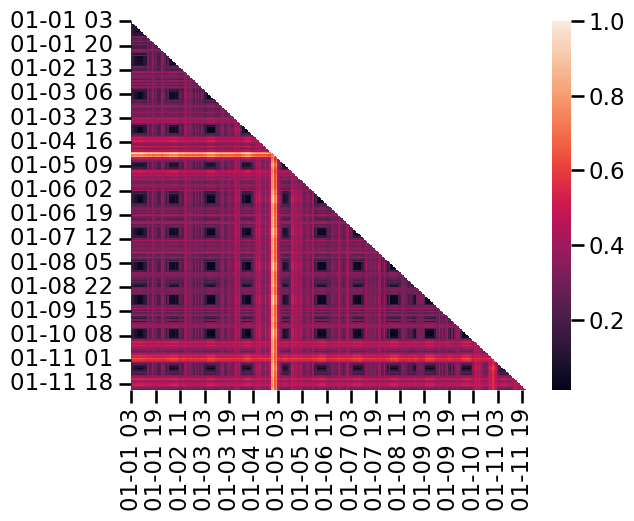

In [189]:
leven_distance_noAlt_df = pd.DataFrame(leven_distance_noAlt, index=hours_noAlt, columns = hours_noAlt)
leven_distance_noAlt_df.index = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_noAlt_df.index]
leven_distance_noAlt_df.columns = [pd.to_datetime( int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in leven_distance_noAlt_df.columns]

leven_distance_noAlt_df = (leven_distance_noAlt_df) / 470

sns.heatmap(leven_distance_noAlt_df)

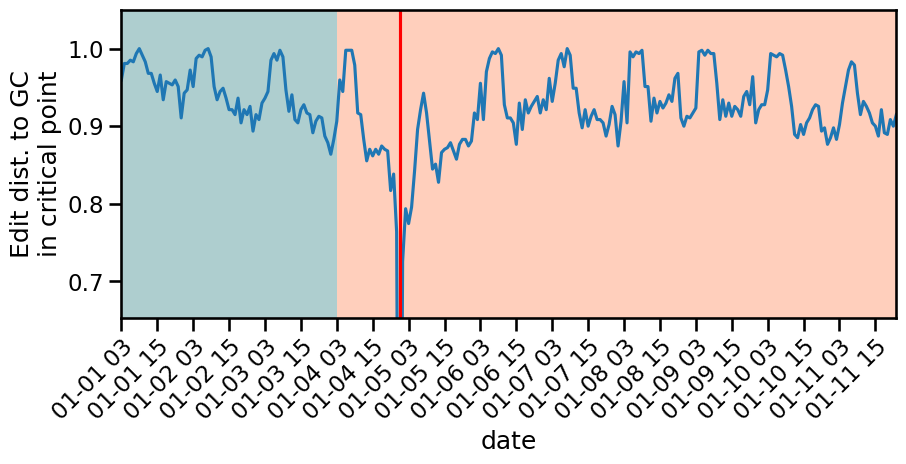

In [193]:
critical_time = '01-05 00'
period_start = '01-04 03'
plot_Levenshtein_Distance(leven_distance_noAlt_df, critical_time, period_start, date_step = 12)

# Node Frequency

## Get high Nestedness date

In [18]:
highest_nest_df = pd.DataFrame()

for file in glob('D:/FV/Personal/VIU/clean_data/graph_metrics_*_clean.csv'):
    net_type = file.split('graph_metrics_')[-1].split('_clean')[0]
    graph_met = pd.read_csv(file, index_col=0)
    graph_met = graph_met[((graph_met.db == '9n') & 
                    (graph_met.hour <= 437059) & 
                    (graph_met.hour >= 436998)) |
              ((graph_met.db != '9n') & 
                    (graph_met.hour >= 429534) & 
                    (graph_met.hour <= 429694)) ]
    hour_no = graph_met[(graph_met.db == 'no') & (graph_met.nest == graph_met[(graph_met.db == 'no')].nest.max()) ].hour[0]
    hour_9n = graph_met[(graph_met.db != 'no') & (graph_met.nest == graph_met[(graph_met.db != 'no')].nest.max()) ].hour[0]

    highest_nest_df = pd.concat([highest_nest_df,pd.DataFrame([[net_type, 'no', hour_no],
                                    [net_type, '9n', hour_9n]])])
    
highest_nest_df.columns = ['net_type', 'db','hour']

highest_nest_df['db'] = highest_nest_df.db.replace('no', 'noAlt') 

highest_nest_df.sort_values('db')

net_type     db    hour
1         bipartite     9n  437037
1  bipartite_trimed     9n  437037
1         hashNodes     9n  437045
1         userNodes     9n  437037
0         bipartite  noAlt  429624
0  bipartite_trimed  noAlt  429624
0         hashNodes  noAlt  429624
0         userNodes  noAlt  429624

## Get High Modularity in bipartite network

In [6]:
dates_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed_clean.csv'

dates = pd.read_csv(dates_path, index_col=0)

dates = dates[((dates.db == '9n') & 
                    (dates.hour <= 437059) & 
                    (dates.hour >= 436998)) |
              ((dates.db != '9n') & 
                    (dates.hour >= 429534) & 
                    (dates.hour <= 429694)) ]

dates_9n = dates[dates.db == '9n']
dates_no = dates[dates.db != '9n']


dates = pd.concat([dates_9n.loc[(dates_9n.total_nr_of_nodes > 0.15*dates_9n.total_nr_of_nodes.max()), :] , 
                   dates_no.loc[(dates_no.total_nr_of_nodes > 0.15*dates_no.total_nr_of_nodes.max()), :]])

dates


db    hour       mod      nest  n_comp  total_nr_of_hashs  \
0   9n  437001  0.684116  0.034037       5                 95   
0   9n  437002  0.653276  0.033726       5                139   
0   9n  437003  0.641575  0.036560       9                147   
0   9n  437004  0.656220  0.035925       9                163   
0   9n  437005  0.641955  0.041942       5                172   
..  ..     ...       ...       ...     ...                ...   
0   no  429688  0.844535  0.017416      16                 72   
0   no  429689  0.852125  0.017452      15                 66   
0   no  429690  0.837257  0.015130      15                 70   
0   no  429693  0.812836  0.012915      14                 77   
0   no  429694  0.844064  0.011490      20                 86   

    total_nr_of_users  total_nr_of_nodes  nr_of_hashs_in_giant_c  \
0                 257                352                      91   
0                 452                591                     133   
0                 571                718                     138   
0                 626                789                     153   
0                 597                769                     168   
..                ...                ...                     ...   
0                 174                246                      50   
0                 167                233                      48   
0                 176                246                      54   
0                 171                248                      64   
0                 168                254                      57   

    nr_of_users_in_giant_c  nr_of_nodes_in_giant_c  is_bipartite  
0                      245                     336          True  
0                      444                     577          True  
0                      553                     691          True  
0                      599                     752          True  
0                      589                     757          True  
..                     ...                     ...           ...  
0                      128                     178          True  
0                      128                     176          True  
0                      138                     192          True  
0                      137                     201          True  
0                      116                     173          True  

[143 rows x 12 columns]

## Node Fre per component

In [10]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['date'] =pd.to_datetime( node_freq_df.hour * 3600, unit='s').dt.strftime('%m-%d %H')



print(node_freq_df.dtypes)
node_freq_df.tail()

node_type         string[python]
node                      object
freq                       Int64
db                string[python]
hour                       int32
hash_comp                  Int64
hash_comp_size             Int64
user_comp                  Int64
user_comp_size             Int64
bip_comp                   Int64
bip_comp_size              Int64
date                      object
dtype: object


node_type                     node  freq     db    hour  hash_comp  \
628   hashtag            lavagadecabal     1  noAlt  429790         12   
629      user                258925451     1  noAlt  429790       <NA>   
630      user                256188370     1  noAlt  429790       <NA>   
631   hashtag              leninmoreno     1  noAlt  429790       <NA>   
632   hashtag  100diasparaadoctrinarse     1  noAlt  429790         19   

     hash_comp_size  user_comp  user_comp_size  bip_comp  bip_comp_size  \
628               5       <NA>            <NA>        13              6   
629            <NA>       <NA>            <NA>        80              2   
630            <NA>         18               2        29              3   
631            <NA>       <NA>            <NA>        79              2   
632               2       <NA>            <NA>        41              3   

         date  
628  01-11 22  
629  01-11 22  
630  01-11 22  
631  01-11 22  
632  01-11 22

In [11]:



def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

    print(reference_nodes_dec)

    def get_node_freq_comp_per_hour(group):
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', comp_col, ]]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_comp_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)




    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    def get_coded_comp(group):
    
        coded_comp_keys = sorted(group.loc[:, comp_col].unique().tolist())

        if not 0 in coded_comp_keys:
            coded_comp_keys = [0] + coded_comp_keys
                                
        coded_comp_dic = {coded_comp_keys[p]:p for p in range(len(coded_comp_keys))}

        coded_comp =  group[comp_col].replace(coded_comp_dic).astype(object)

        return coded_comp

    df['comp'] = df.groupby('hour').apply(lambda group: get_coded_comp(group)).values

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(20, 200), legend=False,
                    palette = sns.color_palette('tab10'),
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = 'noAlt'

for net_type in ['bipartite_trimed', 'hashNodes', 'userNodes']:
    plot_Node_freq()



NameError: name 'highest_nest_df' is not defined

{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: 146497970, 10: '9nmarchaporlajusticia', 11: '9nov', 12: 'queremosdesafuero', 13: 1701362964, 14: 'estoreciencomienza', 15: 'defensoresdelcambio', 16: 'grupodepuebla', 17: 'boliviadijono', 18: 3689259616, 19: 1190989300265103367}
{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: '9nmarchaporlajusticia', 10: '9nov', 11: 'queremosdesafuero', 12: 'estoreciencomienza', 13: 'defensoresdelcambio', 14: 'grupodepuebla', 15: 'boliviadijono', 16: 'fichalimpialovamosalograr', 17: 'evorenunciaya', 18: 'estorecienempieza', 19: 'larebeliondelosmansos'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\4282871991.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_comp_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\4282871991.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_comp(group)).valu

{0: 146497970, 1: 1701362964, 2: 3689259616, 3: 1190989300265103367, 4: 2241185934, 5: 1161479772251312129, 6: 829852435388755968, 7: 169773620, 8: 747562146905595905, 9: 2500762786, 10: 1708188769, 11: 1007234912, 12: 2262051140, 13: 1184330655443890182, 14: 931697515400921090, 15: 884552675429429248, 16: 1537351045, 17: 594891206, 18: 2985597903, 19: 1597329390}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\4282871991.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels);


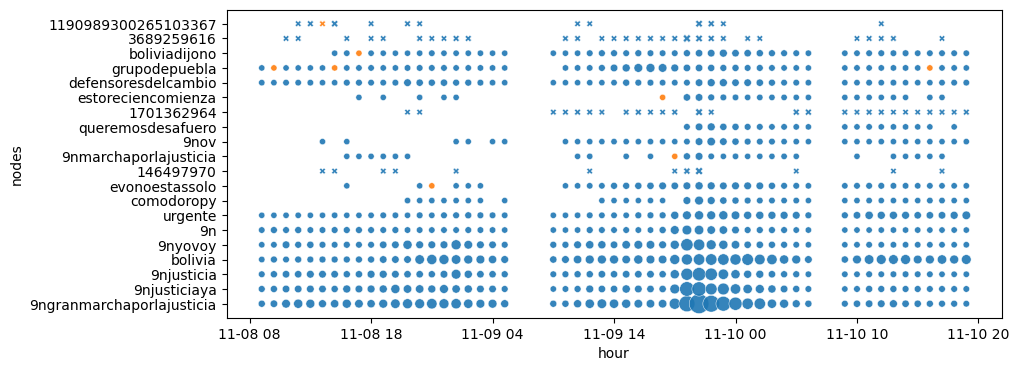

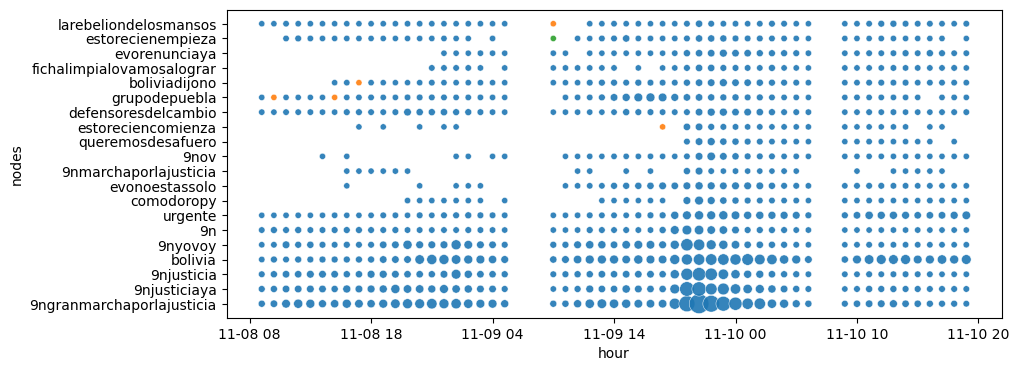

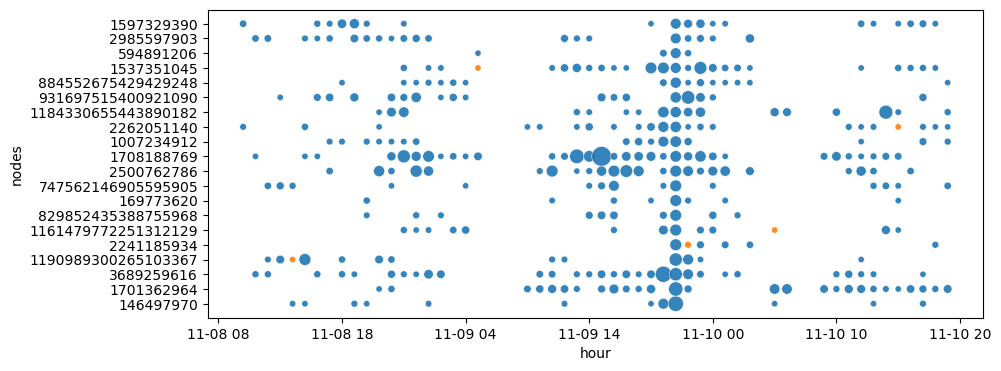

In [ ]:

db = '9n'

for net_type in ['bipartite_trimed', 'hashNodes', 'userNodes']:
    plot_Node_freq()

{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: '9nmarchaporlajusticia', 10: '9nov', 11: 'queremosdesafuero', 12: 'estoreciencomienza', 13: 'defensoresdelcambio', 14: 'grupodepuebla', 15: 'boliviadijono', 16: 'fichalimpialovamosalograr', 17: 'evorenunciaya', 18: 'estorecienempieza', 19: 'larebeliondelosmansos'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1910620227.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_comp_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1910620227.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_comp(group)).valu

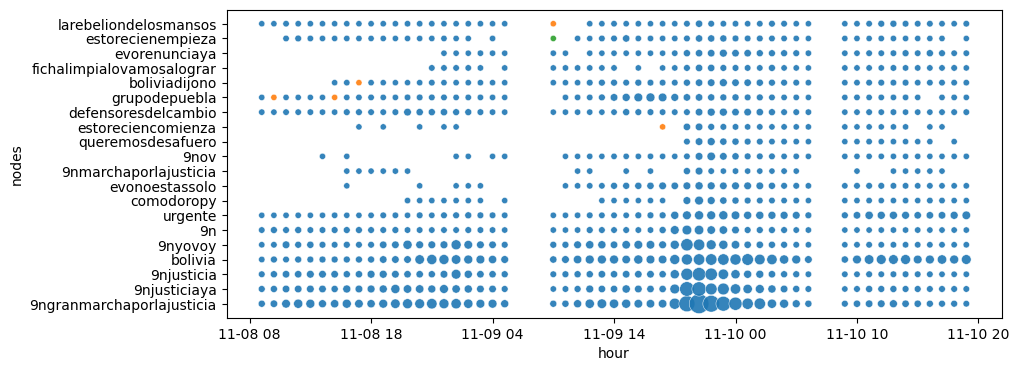

In [337]:
net_type = 'hashNodes'
# db = 'noAlt'
db = '9n'

plot_Node_freq()

In [12]:



def plot_hash_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

    print(reference_nodes_dec)

    def get_node_freq_comp_per_hour(group):
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', comp_col, ]]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_comp_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)




    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    def get_coded_comp(group):
    
        coded_comp_keys = sorted(group.loc[:, comp_col].unique().tolist())

        if not 0 in coded_comp_keys:
            coded_comp_keys = [0] + coded_comp_keys
                                
        coded_comp_dic = {coded_comp_keys[p]:p for p in range(len(coded_comp_keys))}

        coded_comp =  group[comp_col].replace(coded_comp_dic).astype(object)

        return coded_comp

    df['comp'] = df.groupby('hour').apply(lambda group: get_coded_comp(group)).values

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(20, 200), legend=False,
                    palette = sns.color_palette('tab10'),
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = 'noAlt'

for net_type in ['bipartite_trimed', 'hashNodes']:
    plot_hash_freq()



NameError: name 'highest_nest_df' is not defined

In [13]:
db = '9n'

for net_type in ['bipartite_trimed', 'hashNodes']:
    plot_hash_freq()

NameError: name 'highest_nest_df' is not defined

In [14]:



def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

    print(reference_nodes_dec)

    def get_node_freq_comp_per_hour(group):
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', comp_col, ]]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_comp_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)




    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    def get_coded_comp(group):
    
        coded_comp_keys = sorted(group.loc[:, comp_col].unique().tolist())

        if not 0 in coded_comp_keys:
            coded_comp_keys = [0] + coded_comp_keys
                                
        coded_comp_dic = {coded_comp_keys[p]:p for p in range(len(coded_comp_keys))}

        coded_comp =  group[comp_col].replace(coded_comp_dic).astype(object)

        return coded_comp

    df['comp'] = df.groupby('hour').apply(lambda group: get_coded_comp(group)).values

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(20, 200), legend=False,
                    palette = sns.color_palette('tab10'),
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = 'noAlt'

for net_type in ['bipartite_trimed', 'hashNodes', 'userNodes']:
    plot_Node_freq()



NameError: name 'highest_nest_df' is not defined

## Freq per community

In [13]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['date'] =pd.to_datetime( node_freq_df.hour * 3600, unit='s').dt.strftime('%m-%d %H')



print(node_freq_df.dtypes)
node_freq_df.tail()

node_type              string[python]
node                           object
freq                            Int64
db                     string[python]
hour                            int32
hash_community                  Int64
hash_community_size             Int64
user_community                  Int64
user_community_size             Int64
bip_community                   Int64
bip_community_size              Int64
date                           object
dtype: object


node_type                     node  freq     db    hour  hash_community  \
628   hashtag            lavagadecabal     1  noAlt  429790              44   
629      user                258925451     1  noAlt  429790            <NA>   
630      user                256188370     1  noAlt  429790            <NA>   
631   hashtag              leninmoreno     1  noAlt  429790            <NA>   
632   hashtag  100diasparaadoctrinarse     1  noAlt  429790               0   

     hash_community_size  user_community  user_community_size  bip_community  \
628                    5            <NA>                 <NA>           <NA>   
629                 <NA>            <NA>                 <NA>           <NA>   
630                 <NA>              23                    2              8   
631                 <NA>            <NA>                 <NA>           <NA>   
632                    2            <NA>                 <NA>           <NA>   

     bip_community_size      date  
628                <NA>  01-11 22  
629                <NA>  01-11 22  
630                   3  01-11 22  
631                <NA>  01-11 22  
632                <NA>  01-11 22

In [15]:
tmp = node_freq_df.groupby(['db', 'hour'])[['hash_community', 'user_community', 'bip_community']].max().reset_index().melt(id_vars = ['db', 'hour'],var_name = 'net_type', value_name = 'nr. of communities')
# .melt(idvars = var_name = 'net_type', value_name = 'nr. of communities')
# tmp

tmp['hour'] = tmp.hour.astype(int)

g = sns.FacetGrid(data=tmp, col = 'db', sharex=False, aspect = 2)

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'nr. of communities', hue = 'net_type')
g.map_dataframe(sns.lineplot, x = 'hour', y = 'nr. of communities', hue = 'net_type')

g.add_legend()


def add_vline(data, **kwargs):
    db_value = data['db'].iloc[0]
    if db_value == '9n':
        plt.axvline(x=437037, c='r')
    else:
        plt.axvline(x=429624, c='r')
        
# Add the vertical lines using the custom function
g.map_dataframe(add_vline)

for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')

KeyError: "Columns not found: 'hash_community', 'user_community', 'bip_community'"

In [16]:
pd.set_option('future.no_silent_downcasting', True)

db = 'noAlt'

net_type = 'bipartite_trimed'

if 'bipartite' in net_type:
    nodes = ['hashtag', 'user']
    comp_col = 'bip_community'
elif net_type == 'hashNodes':
    nodes = ['hashtag']
    comp_col = 'hash_community'
else:
    nodes = ['user']
    comp_col = 'user_community'
    
n_top_nodes = 20

hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                        (highest_nest_df.db == db), 'hour'].iloc[0]

reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                        (node_freq_df.db == db) &
                        (node_freq_df.hour == hour), : ].sort_values('freq', 
                                        ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

print(reference_nodes_dec)

def get_node_freq_community_per_hour(group):
    group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
    return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'order_' + comp_col, comp_col, comp_col+'_size']]

df = node_freq_df.loc[(node_freq_df.db == db) &
                    (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                    :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
df = df.dropna(subset=comp_col, ).reset_index(drop=True)




df['y_coord'] = df.node.replace(reference_nodes)
df[comp_col] = df[comp_col].astype(object)
df['hour'] = df['hour'].astype(int)
df['y_coord'] = df['y_coord'].astype(int)
df['freq'] = df['freq'].astype(int)

def get_coded_community(group):

    coded_community_keys = sorted(group.loc[:, 'order_' + comp_col].unique().tolist())

    # if not 0 in coded_community_keys:
    #     coded_community_keys = [0] + coded_community_keys
                            
    coded_community_dic = {coded_community_keys[p]:p for p in range(len(coded_community_keys))}

    coded_community =  group[comp_col].replace(coded_community_dic).astype(object)

    return coded_community

# df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values
df['comp'] = df['order_' + comp_col]

def create_discrete_palette(cmap_name, num_colors):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
    return colors


num_colors = df['comp'].nunique()
palette = create_discrete_palette('winter', num_colors)

fig, ax = plt.subplots(1,1, figsize = [10, 4])

sns.scatterplot(data = df, 
                x = 'hour', y = 'y_coord', 
                hue = 'comp',
                style='node_type', size='freq', 
                sizes=(20, 200), legend=False,
                palette = palette,
                ax = ax,
                alpha =.9)

ax.ticklabel_format(useOffset=False)
ax.set_yticks(np.arange(20));

tick_labels = [reference_nodes_dec[p] for p in range(20)]

new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

ax.set_xticklabels(new_xticklabels);
ax.set_yticklabels(tick_labels);
ax.set_ylabel('nodes')

NameError: name 'highest_nest_df' is not defined

34

C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\4202985268.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels);


Text(0, 0.5, 'nodes')

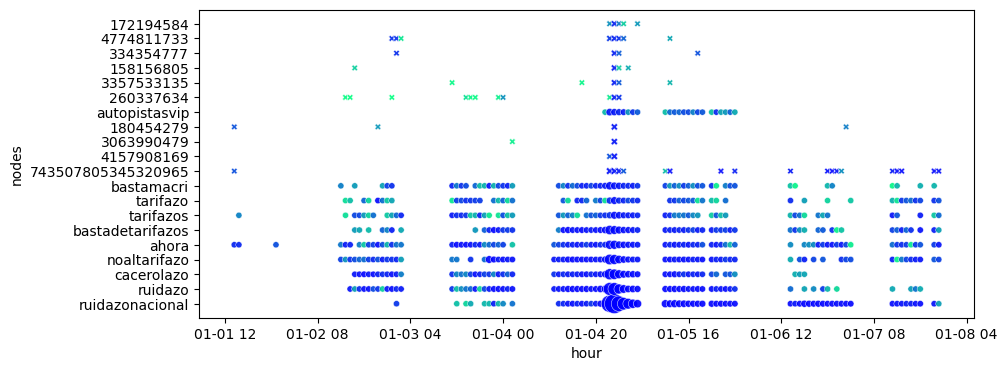

{0: 'ruidazonacional', 1: 'ruidazo', 2: 'cacerolazo', 3: 'noaltarifazo', 4: 'ahora', 5: 'bastadetarifazos', 6: 'tarifazos', 7: 'tarifazo', 8: 'bastamacri', 9: 743507805345320965, 10: 4157908169, 11: 3063990479, 12: 180454279, 13: 'autopistasvip', 14: 260337634, 15: 3357533135, 16: 158156805, 17: 334354777, 18: 4774811733, 19: 172194584}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

{0: 'ruidazonacional', 1: 'ruidazo', 2: 'cacerolazo', 3: 'noaltarifazo', 4: 'ahora', 5: 'bastadetarifazos', 6: 'tarifazos', 7: 'tarifazo', 8: 'bastamacri', 9: 'autopistasvip', 10: 'buenviernes', 11: 'mmlpqtp', 12: 'telefe', 13: 'cacerolazos', 14: 'fuerzadiego', 15: 'laplata', 16: 'fueramacri', 17: 'envivo', 18: 'quilmes', 19: 'mmlpqt'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

{0: 743507805345320965, 1: 4157908169, 2: 3063990479, 3: 180454279, 4: 260337634, 5: 3357533135, 6: 158156805, 7: 334354777, 8: 4774811733, 9: 172194584, 10: 853657010654638081, 11: 196412229, 12: 163246260, 13: 354635340, 14: 1318486856, 15: 1390533390, 16: 293327492, 17: 1210013696, 18: 168254714, 19: 2949563344}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

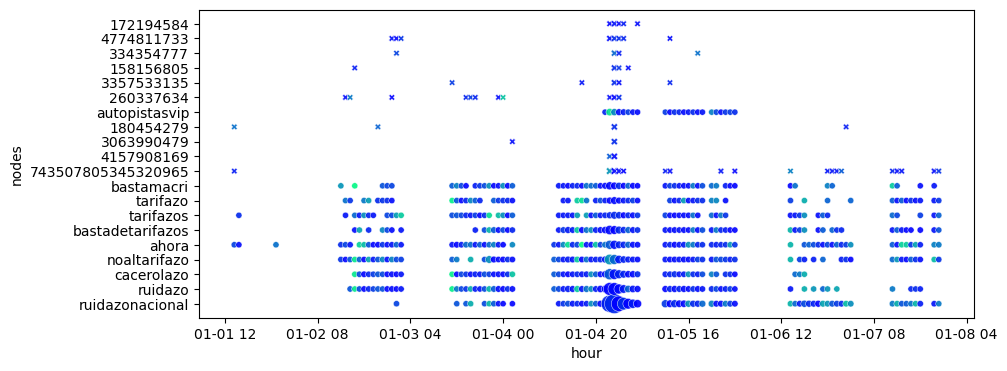

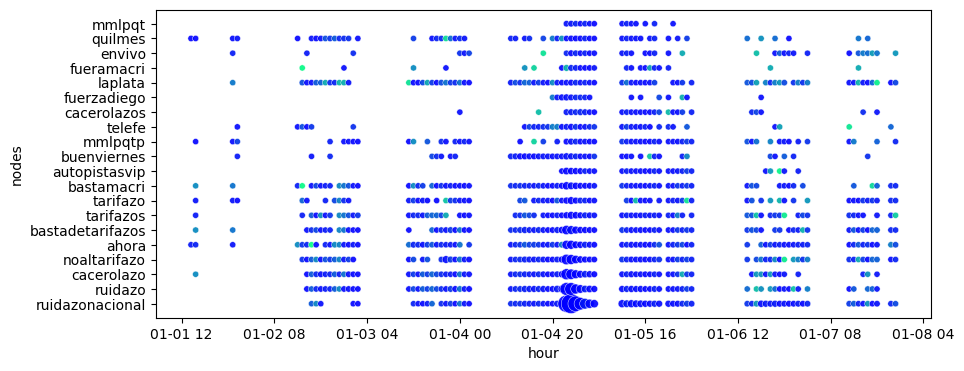

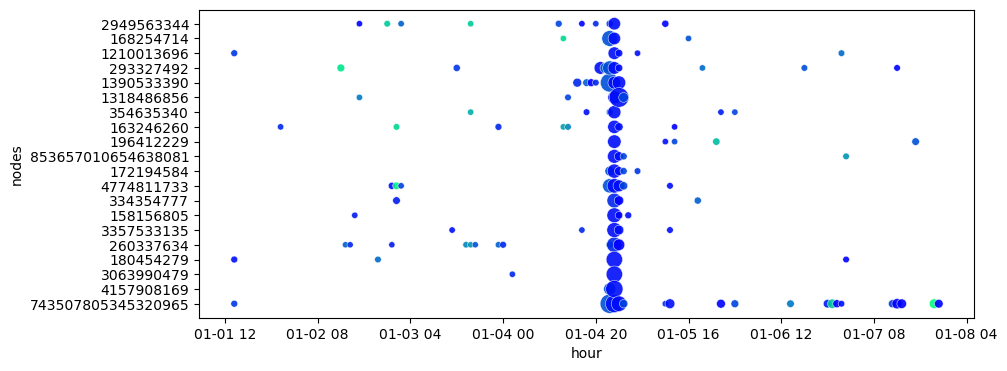

In [160]:
def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_community'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_community'
    else:
        nodes = ['user']
        comp_col = 'user_community'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

    print(reference_nodes_dec)

    def get_node_freq_community_per_hour(group):
        group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'order_' + comp_col, comp_col, comp_col+'_size']]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)

    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    def get_coded_community(group):

        coded_community_keys = sorted(group.loc[:, 'order_' + comp_col].unique().tolist())

        # if not 0 in coded_community_keys:
        #     coded_community_keys = [0] + coded_community_keys
                                
        coded_community_dic = {coded_community_keys[p]:p for p in range(len(coded_community_keys))}

        coded_community =  group[comp_col].replace(coded_community_dic).astype(object)

        return coded_community

    df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values
    # df['comp'] = df['order_' + comp_col]

    def create_discrete_palette(cmap_name, num_colors):
        cmap = plt.get_cmap(cmap_name)
        colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
        return colors


    num_colors = df['comp'].nunique()
    palette = create_discrete_palette('winter', num_colors)

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(20, 200), legend=False,
                    palette = palette,
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = 'noAlt'

for net_type in ['bipartite_trimed', 'hashNodes', 'userNodes']:
    plot_Node_freq()



{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: 146497970, 10: '9nmarchaporlajusticia', 11: '9nov', 12: 'queremosdesafuero', 13: 1701362964, 14: 'estoreciencomienza', 15: 'defensoresdelcambio', 16: 'grupodepuebla', 17: 'boliviadijono', 18: 3689259616, 19: 1190989300265103367}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: '9nmarchaporlajusticia', 10: '9nov', 11: 'queremosdesafuero', 12: 'estoreciencomienza', 13: 'defensoresdelcambio', 14: 'grupodepuebla', 15: 'boliviadijono', 16: 'fichalimpialovamosalograr', 17: 'evorenunciaya', 18: 'estorecienempieza', 19: 'larebeliondelosmansos'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

{0: 146497970, 1: 1701362964, 2: 3689259616, 3: 1190989300265103367, 4: 2241185934, 5: 1161479772251312129, 6: 829852435388755968, 7: 169773620, 8: 747562146905595905, 9: 2500762786, 10: 1708188769, 11: 1007234912, 12: 2262051140, 13: 1184330655443890182, 14: 931697515400921090, 15: 884552675429429248, 16: 1537351045, 17: 594891206, 18: 2985597903, 19: 1597329390}


C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_36908\728540996.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(

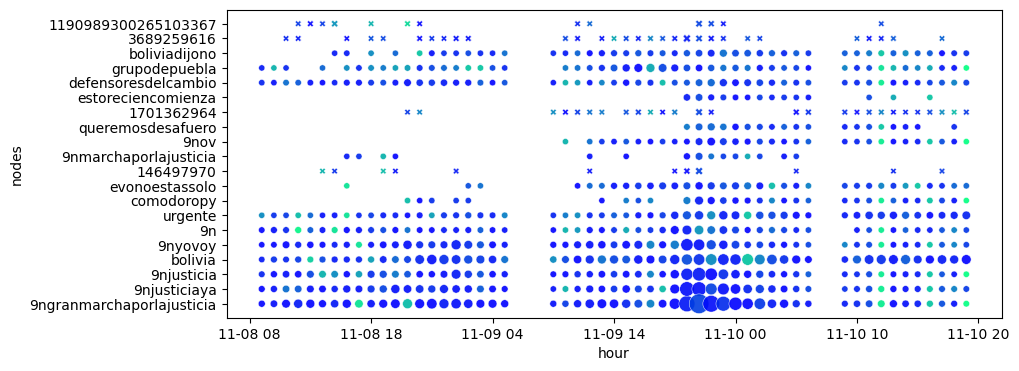

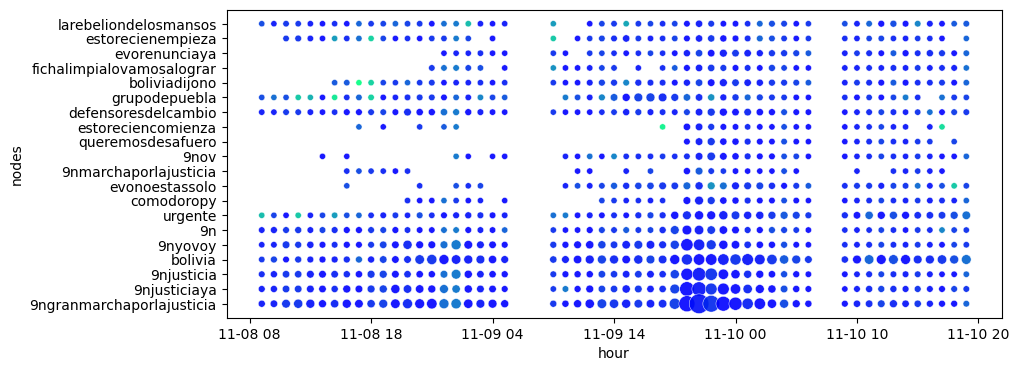

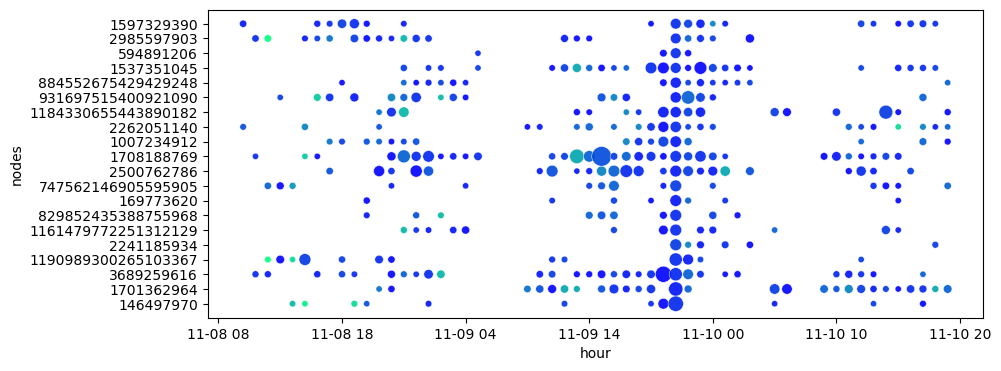

In [161]:
db = '9n'

for net_type in ['bipartite_trimed', 'hashNodes', 'userNodes']:
    plot_Node_freq()

{0: 'ruidazonacional', 1: 'ruidazo', 2: 'cacerolazo', 3: 'noaltarifazo', 4: 'ahora', 5: 'bastadetarifazos', 6: 'tarifazos', 7: 'tarifazo', 8: 'bastamacri', 9: 'autopistasvip', 10: 'buenviernes', 11: 'mmlpqtp', 12: 'telefe', 13: 'cacerolazos', 14: 'fuerzadiego', 15: 'laplata', 16: 'fueramacri', 17: 'envivo', 18: 'quilmes', 19: 'mmlpqt'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(gr

{0: 'ruidazonacional', 1: 'ruidazo', 2: 'cacerolazo', 3: 'noaltarifazo', 4: 'ahora', 5: 'bastadetarifazos', 6: 'tarifazos', 7: 'tarifazo', 8: 'bastamacri', 9: 'autopistasvip', 10: 'buenviernes', 11: 'mmlpqtp', 12: 'telefe', 13: 'cacerolazos', 14: 'fuerzadiego', 15: 'laplata', 16: 'fueramacri', 17: 'envivo', 18: 'quilmes', 19: 'mmlpqt'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(gr

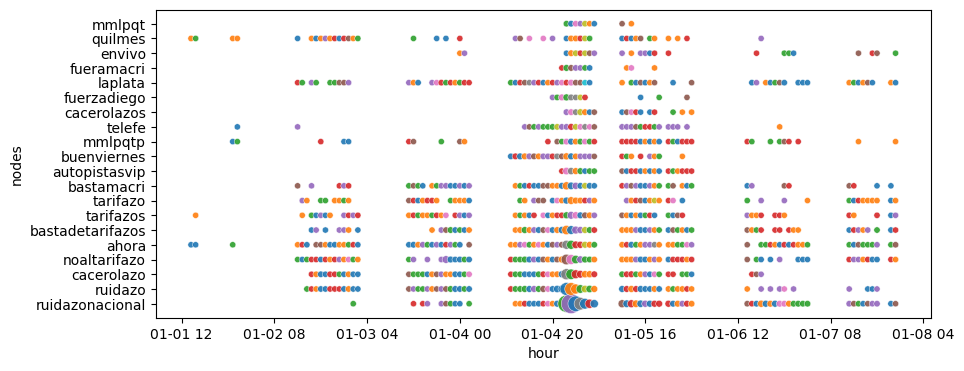

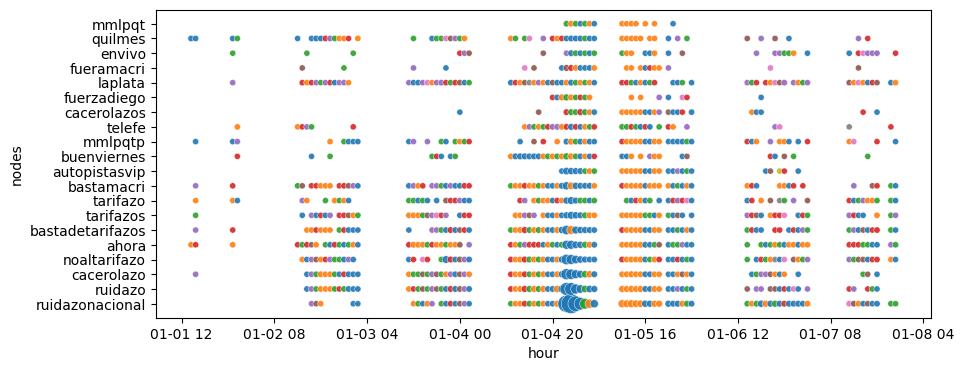

In [503]:



def plot_hash_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag']
        comp_col = 'bip_community'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_community'
    else:
        nodes = ['user']
        comp_col = 'user_community'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

    print(reference_nodes_dec)

    def get_node_freq_community_per_hour(group):
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', comp_col, ]]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)




    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    def get_coded_community(group):
    
        coded_community_keys = sorted(group.loc[:, comp_col].unique().tolist())

        coded_community_dic = {coded_community_keys[p]:p for p in range(len(coded_community_keys))}

        coded_community =  group[comp_col].replace(coded_community_dic).astype(object)

        return coded_community

    df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(20, 200), legend=False,
                    palette = sns.color_palette('tab10'),
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = 'noAlt'

for net_type in ['bipartite_trimed', 'hashNodes']:
    plot_hash_freq()



{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: '9nmarchaporlajusticia', 10: '9nov', 11: 'queremosdesafuero', 12: 'estoreciencomienza', 13: 'defensoresdelcambio', 14: 'grupodepuebla', 15: 'boliviadijono', 16: 'fichalimpialovamosalograr', 17: 'evorenunciaya', 18: 'estorecienempieza', 19: 'larebeliondelosmansos'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(gr

{0: '9ngranmarchaporlajusticia', 1: '9njusticiaya', 2: '9njusticia', 3: 'bolivia', 4: '9nyovoy', 5: '9n', 6: 'urgente', 7: 'comodoropy', 8: 'evonoestassolo', 9: '9nmarchaporlajusticia', 10: '9nov', 11: 'queremosdesafuero', 12: 'estoreciencomienza', 13: 'defensoresdelcambio', 14: 'grupodepuebla', 15: 'boliviadijono', 16: 'fichalimpialovamosalograr', 17: 'evorenunciaya', 18: 'estorecienempieza', 19: 'larebeliondelosmansos'}


C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:58: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data = df,
C:\Users\neuro\AppData\Local\Temp\ipykernel_832\1594990574.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels);


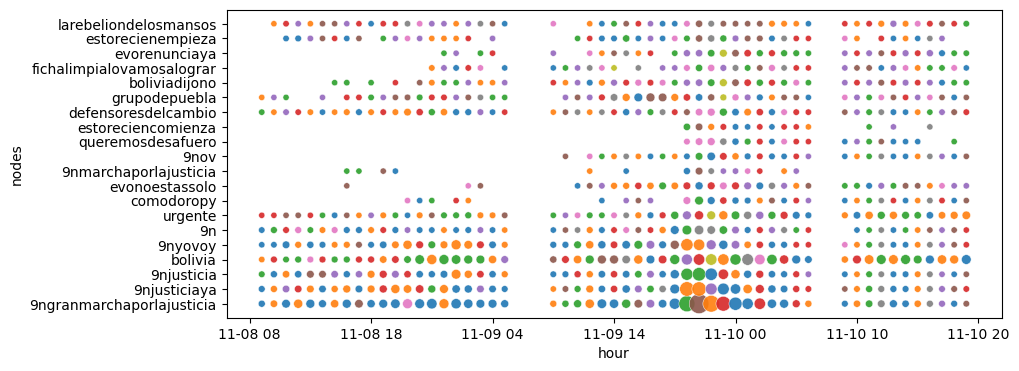

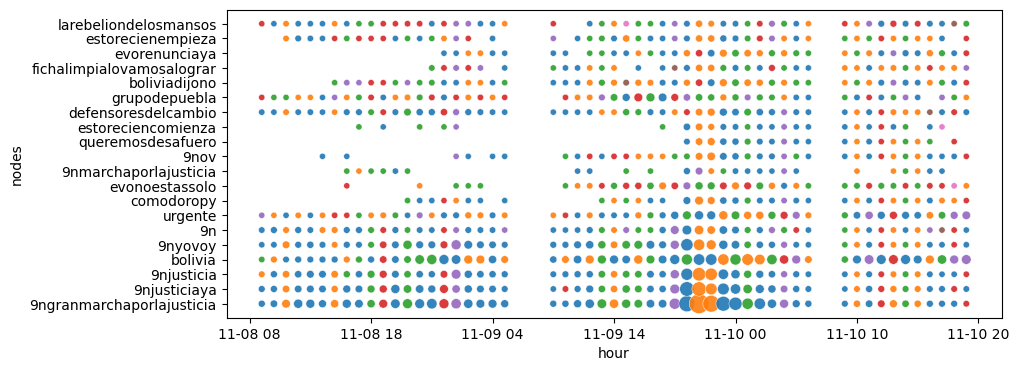

In [504]:
db = '9n'

for net_type in ['bipartite_trimed', 'hashNodes']:
    plot_hash_freq()

# Node centralities

### Join pagerank to centralities

### Page rank

In [ ]:
# Function to get PageRank values for reference nodes
def get_pagerank(comp_metrics, db, reference_nodes, net_type):
    PageRanks = []
    for hour in comp_metrics[db].keys(): 
        for key in reference_nodes.keys():
            try:
                pr = comp_metrics[db][hour]['pagerank'][key]
            except KeyError:
                pr = 0 
            PageRanks.append([db, hour, net_type, key, 'pagerank', pr])
    return PageRanks

# Function to find the node with the largest PageRank
def get_key_with_largest_value(dic):
    # Sorting the dictionary by its values to get the key with the largest value
    sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
    key = list(sorted_dict.keys())[0]
    value = sorted_dict[key]
    return key, value

# Function to get the largest PageRank values for each hour
def get_largest_pagerank(comp_metrics, db, net_type):
    PageRanks = []
    largest_pageranks = []
    for hour in comp_metrics[db].keys(): 
        key, pr = get_key_with_largest_value(comp_metrics[db][hour]['pagerank'])
        largest_pageranks.append([db, hour, net_type, key, 'pagerank', pr])

        for key in comp_metrics[db][hour]['pagerank'].keys():
            try:
                pr = comp_metrics[db][hour]['pagerank'][key]
            except KeyError:
                pr = 0 
            
            PageRanks.append([db, hour, net_type, key, 'pagerank', pr])
            
    return PageRanks, largest_pageranks

# Placeholder for the PageRank and k-core data collection
kcores = []
largest_pageranks_all = []
for net_type in ['bipartite', 'hashNodes', 'userNodes']:

    # def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/pageRank_kCore_{}.pickle'.format(net_type)

    with open(comp_metrics_path, 'rb') as handle:
        comp_metrics = pickle.load(handle)

    n_top_nodes = 5

    for db in ['9n', 'noAlt']:
        hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

        reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                                (node_freq_df.db == db) &
                                (node_freq_df.hour == hour), : ].sort_values('freq', 
                                                ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()
        
        get_pagerank(comp_metrics, db, reference_nodes, net_type)
        # Get PageRank data and largest PageRank nodes
        pageranks, largest_pageranks = get_largest_pagerank(comp_metrics, db, net_type)
        
        kcores += pageranks
        largest_pageranks_all += largest_pageranks

# Convert to DataFrames
PageRanks_df = pd.DataFrame(kcores, columns=['db', 'hour', 'net_type', 'node', 'measure', 'value'])

PageRanks_df.hour = PageRanks_df.hour.astype(int)
PageRanks_df = PageRanks_df[((PageRanks_df.db == '9n') & 
                    (PageRanks_df.hour <= 437059) & 
                    (PageRanks_df.hour >= 436998)) |
              ((PageRanks_df.db != '9n') & 
                    (PageRanks_df.hour >= 429534) & 
                    (PageRanks_df.hour <= 429694)) ].reset_index(drop = True)

largest_pageranks_df = pd.DataFrame(largest_pageranks_all, columns=['db', 'hour', 'net_type', 'node_largest', 'measure', 'value_largest'])

largest_pageranks_df.hour = largest_pageranks_df.hour.astype(int)
largest_pageranks_df = largest_pageranks_df[((largest_pageranks_df.db == '9n') & 
                    (largest_pageranks_df.hour <= 437059) & 
                    (largest_pageranks_df.hour >= 436998)) |
              ((largest_pageranks_df.db != '9n') & 
                    (largest_pageranks_df.hour >= 429534) & 
                    (largest_pageranks_df.hour <= 429694)) ].reset_index(drop = True)

# Set size based on the largest PageRank node, similar to PageRanks_df
PageRanks_df = PageRanks_df.merge(largest_pageranks_df, on=['db', 'hour', 'net_type', 'measure'], how='left')

# Assign size based on whether the node is the largest pagerank
PageRanks_df['size'] = PageRanks_df.apply(lambda row: 10 if row['node'] == row['node_largest'] else 1, axis=1)

# Drop auxiliary columns for a clean output, similar to PageRanks_df
PageRanks_df = PageRanks_df.drop(columns=['node_largest', 'value_largest'])


PageRanks_df = PageRanks_df.merge(largest_pageranks_df, on = ['db', 'hour', 'net_type', 'measure'], suffixes=['','_largest'], how = 'left')

PageRanks_df.loc[PageRanks_df.node == PageRanks_df.node_largest, 'size'] = 10
PageRanks_df.loc[PageRanks_df.node != PageRanks_df.node_largest, 'size'] = 1


largest_nodes_clean_df = PageRanks_df.loc[PageRanks_df.node != PageRanks_df.node_largest, 
                            ['db', 'hour', 'net_type','measure','value_largest', 'size']
                            ].melt(id_vars=['db', 'hour', 'net_type', 'measure', 'size'], var_name='node')


PageRanks_df = pd.concat([PageRanks_df.drop(columns = ['node_largest', 'value_largest']),
    largest_nodes_clean_df])

PageRanks_df['node'] = PageRanks_df.node.replace({'value_largest':'largest'})

PageRanks_df


db    hour   net_type                node   measure     value  size
0          9n  436998  bipartite          1387475166  pagerank  0.025483     1
1          9n  436998  bipartite     animalessueltos  pagerank  0.020922     1
2          9n  436998  bipartite           bastababy  pagerank  0.040934    10
3          9n  436998  bipartite  930188637102329856  pagerank  0.014294     1
4          9n  436998  bipartite  cambiosparasiempre  pagerank  0.014815     1
...       ...     ...        ...                 ...       ...       ...   ...
223173  noAlt  429694  userNodes             largest  pagerank  0.015250     1
223174  noAlt  429694  userNodes             largest  pagerank  0.015250     1
223175  noAlt  429694  userNodes             largest  pagerank  0.015250     1
223176  noAlt  429694  userNodes             largest  pagerank  0.015250     1
223177  noAlt  429694  userNodes             largest  pagerank  0.015250     1

[447025 rows x 7 columns]

In [28]:
def get_centrality_measures(comp_metrics, pr_metrics, db, reference_nodes, net_type):
    centrality_measures = []
    for hour in comp_metrics[db].keys(): 
        for key in reference_nodes.keys():

            try:
                degree = comp_metrics[db][hour]['degree'][key]
            except KeyError:
                degree = 0 
        
            try:
                degree_cent = comp_metrics[db][hour]['degree_cent'][key]
            except KeyError:
                degree_cent = 0 

            try:
                closeness_cent = comp_metrics[db][hour]['closeness_cent'][key]
            except KeyError:
                closeness_cent = 0 
            
            try:
                eigen_cent = comp_metrics[db][hour]['eigen_cent'][key]
            except (KeyError, TypeError) as e:
                if e == TypeError:
                    eigen_cent = np.nan
                else:
                    eigen_cent = 0 

            try:
                between_cent = comp_metrics[db][hour]['between_cent'][key]
            except (KeyError, TypeError) as e:
                if e == TypeError:
                    between_cent = np.nan
                else:
                    between_cent = 0 
            try:
                pr = pr_metrics[db][hour]['pagerank'][key]
            except KeyError:
                pr = 0 

            centrality_measures.append([db, hour, net_type, key, 'degree', degree])
            centrality_measures.append([db, hour, net_type, key, 'degree_cent', degree_cent])
            centrality_measures.append([db, hour, net_type, key, 'closeness_cent', closeness_cent])
            centrality_measures.append([db, hour, net_type, key, 'eigen_cent', eigen_cent])
            centrality_measures.append([db, hour, net_type, key, 'between_cent', between_cent])
            centrality_measures.append([db, hour, net_type, key, 'pagerank', pr])
    return centrality_measures

def get_key_with_largest_value(dic):
    my_dict = dic
    # Sorting the dictionary by its values
    sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
    key = list(sorted_dict.keys())[0]
    value = sorted_dict[key]
    return key, value


def get_largest_centrality(comp_metrics, pr_metrics, db, net_type):
    largest_cent = []
    for hour in comp_metrics[db].keys(): 
        key_degree, degree = get_key_with_largest_value(comp_metrics[db][hour]['degree'])
        largest_cent.append([db, hour, net_type, key_degree, 'degree', degree])

        key_degree_cent, degree_cent = get_key_with_largest_value(comp_metrics[db][hour]['degree_cent'])
        largest_cent.append([db, hour, net_type, key_degree_cent, 'degree_cent', degree_cent])
            
        key_closeness_cent, closeness_cent = get_key_with_largest_value(comp_metrics[db][hour]['closeness_cent'])
        largest_cent.append([db, hour, net_type, key_closeness_cent, 'closeness_cent', closeness_cent])

        try:
            key_eigen_cent, eigen_cent = get_key_with_largest_value(comp_metrics[db][hour]['eigen_cent'])
            largest_cent.append([db, hour, net_type, key_eigen_cent, 'eigen_cent', eigen_cent])
        except:
            print(comp_metrics[db][hour]['eigen_cent'])

        try:
            key_between_cent, between_cent = get_key_with_largest_value(comp_metrics[db][hour]['between_cent'])
            largest_cent.append([db, hour, net_type, key_between_cent, 'between_cent', between_cent])
        except:
            print(comp_metrics[db][hour]['between_cent'])
        try:
            key_pr, pr = get_key_with_largest_value(pr_metrics[db][hour]['pagerank'])
            largest_cent.append([db, hour, net_type, key_pr, 'pagerank', pr])
        except:
            print(comp_metrics[db][hour]['pagerank'])

        
    return largest_cent


largest_cent = []

centrality_measures = []

for net_type in ['bipartite', 'hashNodes', 'userNodes']:

    # def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/compGiant_metrics_{}.pickle'.format(net_type)
    pr_metrics_path = 'D:/FV/Personal/VIU/clean_data/pageRank_kCore_giantComp_{}.pickle'.format(net_type)

    # comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/comp_metrics_{}.pickle'.format(net_type)
    # pr_metrics_path = 'D:/FV/Personal/VIU/clean_data/pageRank_kCore_{}.pickle'.format(net_type)

    with open(comp_metrics_path, 'rb') as handle:
        comp_metrics = pickle.load(handle)

    with open(pr_metrics_path, 'rb') as handle:
        pr_metrics = pickle.load(handle)
    
    n_top_nodes = 5


    for db in ['9n', 'noAlt']:

        hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

        reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                                (node_freq_df.db == db) &
                                (node_freq_df.hour == hour), : ].sort_values('freq', 
                                                ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

        reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

        centrality_measures += get_centrality_measures(comp_metrics, pr_metrics, db, reference_nodes, net_type)

        largest_cent += get_largest_centrality(comp_metrics, pr_metrics, db, net_type)
 

centrality_measures_df = pd.DataFrame(centrality_measures, columns=['db', 'hour', 'net_type', 'node', 'measure', 'value'])

centrality_measures_df.hour = centrality_measures_df.hour.astype(int)
centrality_measures_df = centrality_measures_df[((centrality_measures_df.db == '9n') & 
                    (centrality_measures_df.hour <= 437059) & 
                    (centrality_measures_df.hour >= 436998)) |
              ((centrality_measures_df.db != '9n') & 
                    (centrality_measures_df.hour >= 429534) & 
                    (centrality_measures_df.hour <= 429694)) ].reset_index(drop = True)

largest_cent_df = pd.DataFrame(largest_cent, columns=['db', 'hour', 'net_type', 'node', 'measure', 'value'])

largest_cent_df.hour = largest_cent_df.hour.astype(int)
largest_cent_df = largest_cent_df[((largest_cent_df.db == '9n') & 
                    (largest_cent_df.hour <= 437059) & 
                    (largest_cent_df.hour >= 436998)) |
              ((largest_cent_df.db != '9n') & 
                    (largest_cent_df.hour >= 429534) & 
                    (largest_cent_df.hour <= 429694)) ].reset_index(drop = True)

centrality_measures_df = centrality_measures_df.merge(largest_cent_df, on = ['db', 'hour', 'net_type', 'measure'], suffixes=['','_largest'], how = 'left')

centrality_measures_df.loc[centrality_measures_df.node == centrality_measures_df.node_largest, 'size'] = 10
centrality_measures_df.loc[centrality_measures_df.node != centrality_measures_df.node_largest, 'size'] = 1


largest_nodes_clean_df = centrality_measures_df.loc[centrality_measures_df.node != centrality_measures_df.node_largest, 
                            ['db', 'hour', 'net_type','measure','value_largest', 'size']
                            ].melt(id_vars=['db', 'hour', 'net_type', 'measure', 'size'], var_name='node')


centrality_measures_df = pd.concat([centrality_measures_df.drop(columns = ['node_largest', 'value_largest']),
    largest_nodes_clean_df])

centrality_measures_df['node'] = centrality_measures_df.node.replace({'value_largest':'largest'})

centrality_measures_df

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


db    hour   net_type                       node         measure  \
0         9n  436998  bipartite  9ngranmarchaporlajusticia          degree   
1         9n  436998  bipartite  9ngranmarchaporlajusticia     degree_cent   
2         9n  436998  bipartite  9ngranmarchaporlajusticia  closeness_cent   
3         9n  436998  bipartite  9ngranmarchaporlajusticia      eigen_cent   
4         9n  436998  bipartite  9ngranmarchaporlajusticia    between_cent   
...      ...     ...        ...                        ...             ...   
18873  noAlt  429694  userNodes                    largest     degree_cent   
18874  noAlt  429694  userNodes                    largest  closeness_cent   
18875  noAlt  429694  userNodes                    largest      eigen_cent   
18876  noAlt  429694  userNodes                    largest    between_cent   
18877  noAlt  429694  userNodes                    largest        pagerank   

           value  size  
0      18.000000   1.0  
1       0.123288   1.0  
2       0.323009   1.0  
3       0.040509   1.0  
4       0.207453   1.0  
...          ...   ...  
18873   0.234783   1.0  
18874   0.437262   1.0  
18875   0.258179   1.0  
18876   0.399201   1.0  
18877   0.022090   1.0  

[38948 rows x 7 columns]

C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\4142049750.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\4142049750.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\4142049750.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\4142049750.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

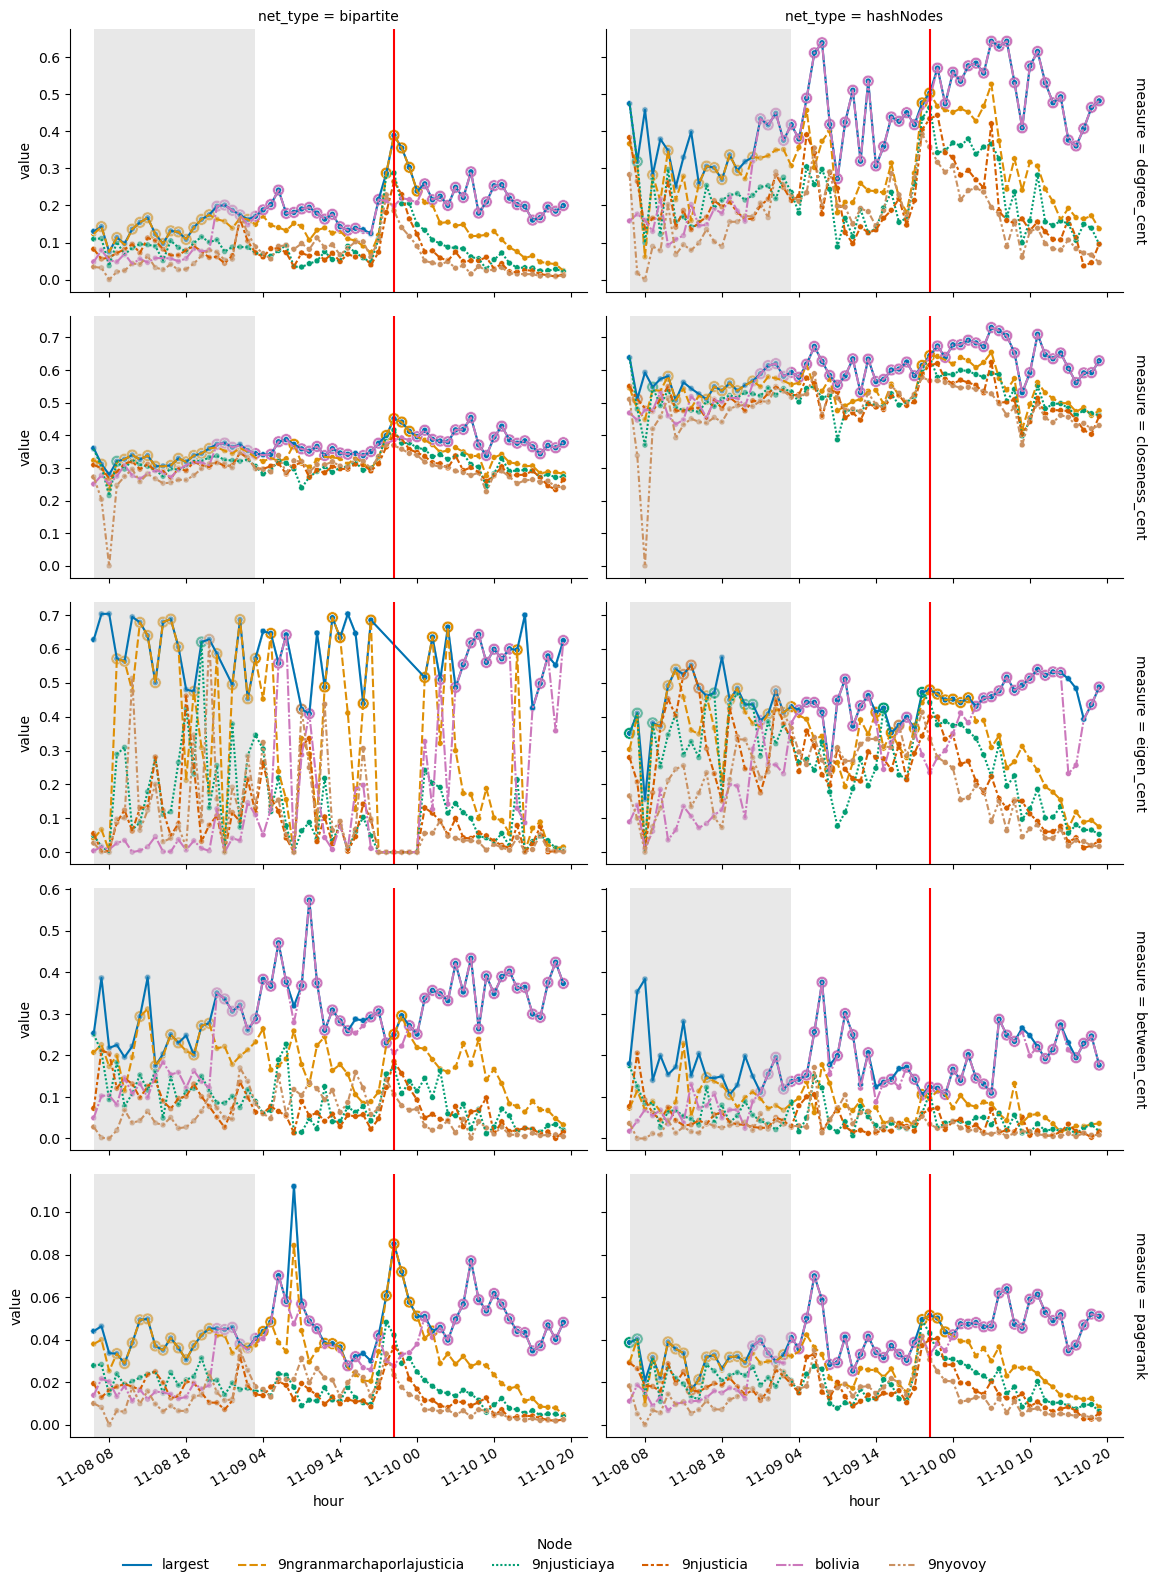

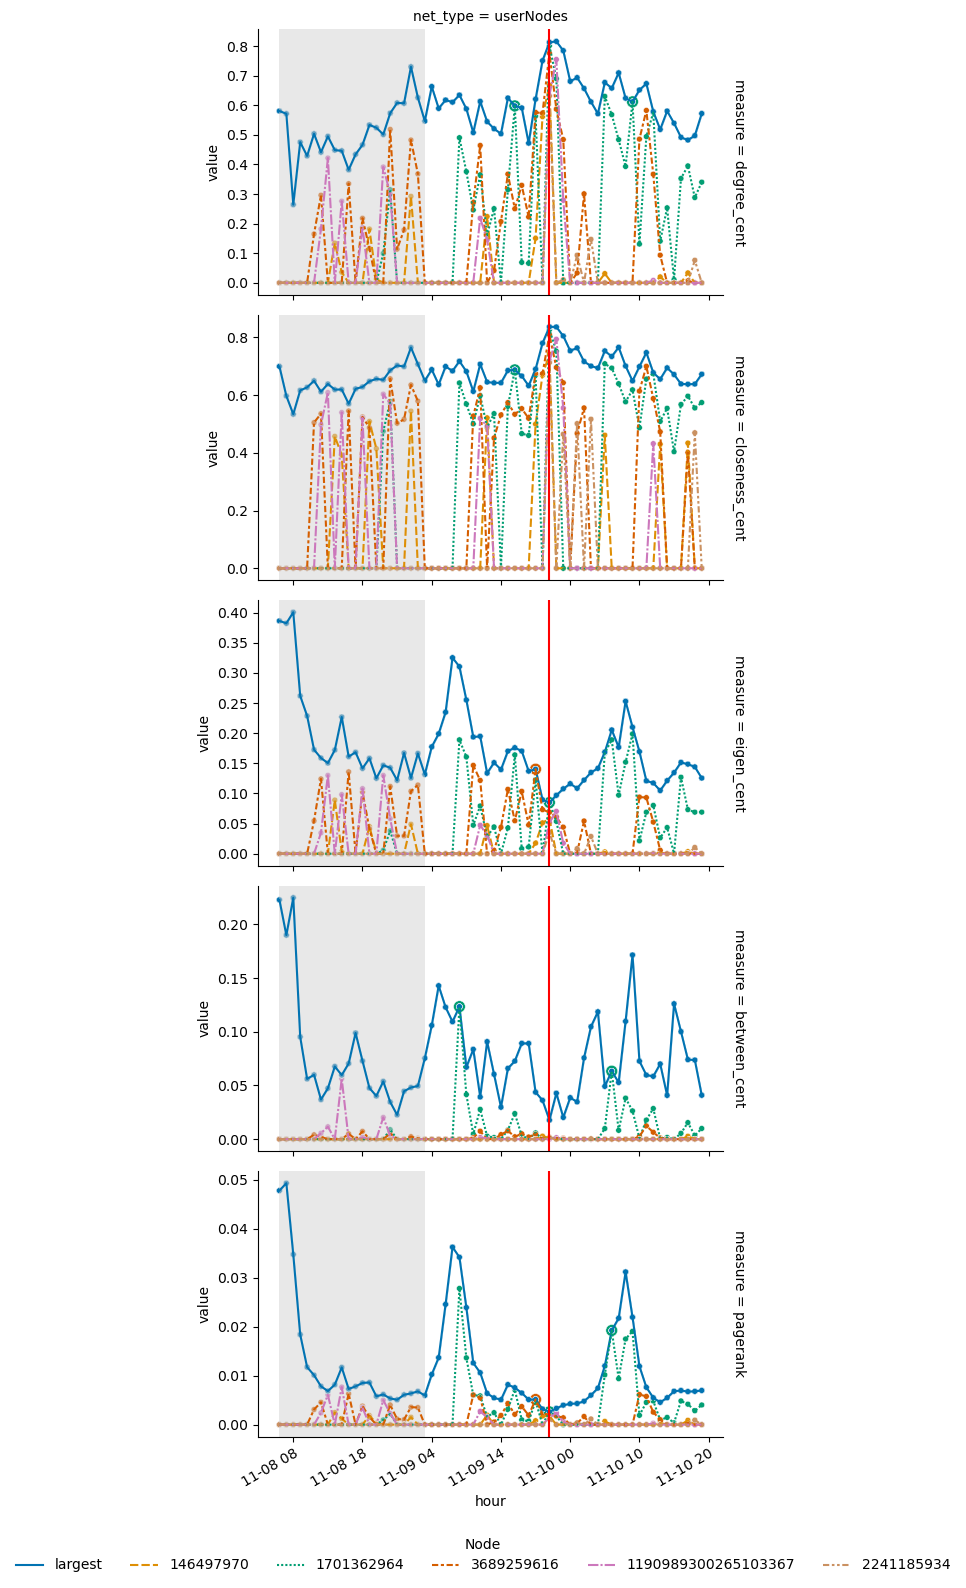

In [32]:
db = '9n'

freq_hour_df = centrality_measures_df[(centrality_measures_df.db == db) & 
                            (centrality_measures_df.measure != 'degree') & #(centrality_measures_df.measure != 'between_cent') &
                            (centrality_measures_df.net_type != 'userNodes')].reset_index(drop = True)

hue_order = ['largest'] + [node for node in freq_hour_df.node.unique() if node != 'largest']


# Define shading parameters based on the database
if db == '9n':
    date_cutoff = int(pd.to_datetime('2019-11-09 03:00').timestamp() / 3600)
    highlight_date = int(pd.to_datetime('2019-11-09 21:00').timestamp() / 3600)
elif db == 'no':
    date_cutoff = int(pd.to_datetime('2019-01-04 03:00').timestamp() / 3600)
    highlight_date = int(pd.to_datetime('2019-01-05 00:00').timestamp() / 3600)


# First set of plots
g = sns.FacetGrid(data=freq_hour_df, row='measure', col='net_type', margin_titles=True, aspect=2, sharey='row')
g.map_dataframe(sns.scatterplot, x='hour', y='value', hue='node', hue_order=hue_order, size='size', palette='colorblind', legend=False)
g.map_dataframe(sns.lineplot, x='hour', y='value', hue='node', hue_order=hue_order, style='node', style_order=hue_order, palette='colorblind')
g.add_legend()
sns.move_legend(g, "center", bbox_to_anchor=(0.4, -0.04), ncol=6, title="Node")

# Add vertical and shaded area based on db
for ax in g.axes.flat:
    ax.axvline(x=highlight_date, c='red')  # Vertical highlight line
    ax.axvspan(freq_hour_df['hour'].min(), date_cutoff, facecolor='lightgray', alpha=0.5)  # Shaded area
    
    # Custom x-axis tick labels
    current_labels = ax.get_xticks()
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')

freq_hour_df = centrality_measures_df[(centrality_measures_df.db == db) & 
                            (centrality_measures_df.measure != 'degree') & #(centrality_measures_df.measure != 'between_cent') &
                            (centrality_measures_df.net_type == 'userNodes')].reset_index(drop = True)

hue_order = ['largest'] + [node for node in freq_hour_df.node.unique() if node != 'largest']

# Second set of plots (for 'userNodes')
g = sns.FacetGrid(data=freq_hour_df, row='measure', col='net_type', margin_titles=True, aspect=2, sharey='row')
g.map_dataframe(sns.scatterplot, x='hour', y='value', hue='node', hue_order=hue_order, size='size', palette='colorblind', legend=False)
g.map_dataframe(sns.lineplot, x='hour', y='value', hue='node', hue_order=hue_order, style='node', style_order=hue_order, palette='colorblind')
g.add_legend()
sns.move_legend(g, "center", bbox_to_anchor=(0.4, -0.04), ncol=6, title="Node")

# Add vertical and shaded area based on db for userNodes plots
for ax in g.axes.flat:
    ax.axvline(x=highlight_date, c='red')  # Vertical highlight line
    ax.axvspan(freq_hour_df['hour'].min(), date_cutoff, facecolor='lightgray', alpha=0.5)  # Shaded area
    
    # Custom x-axis tick labels
    current_labels = ax.get_xticks()
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')


C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\1652788650.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\1652788650.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\1652788650.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_22112\1652788650.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

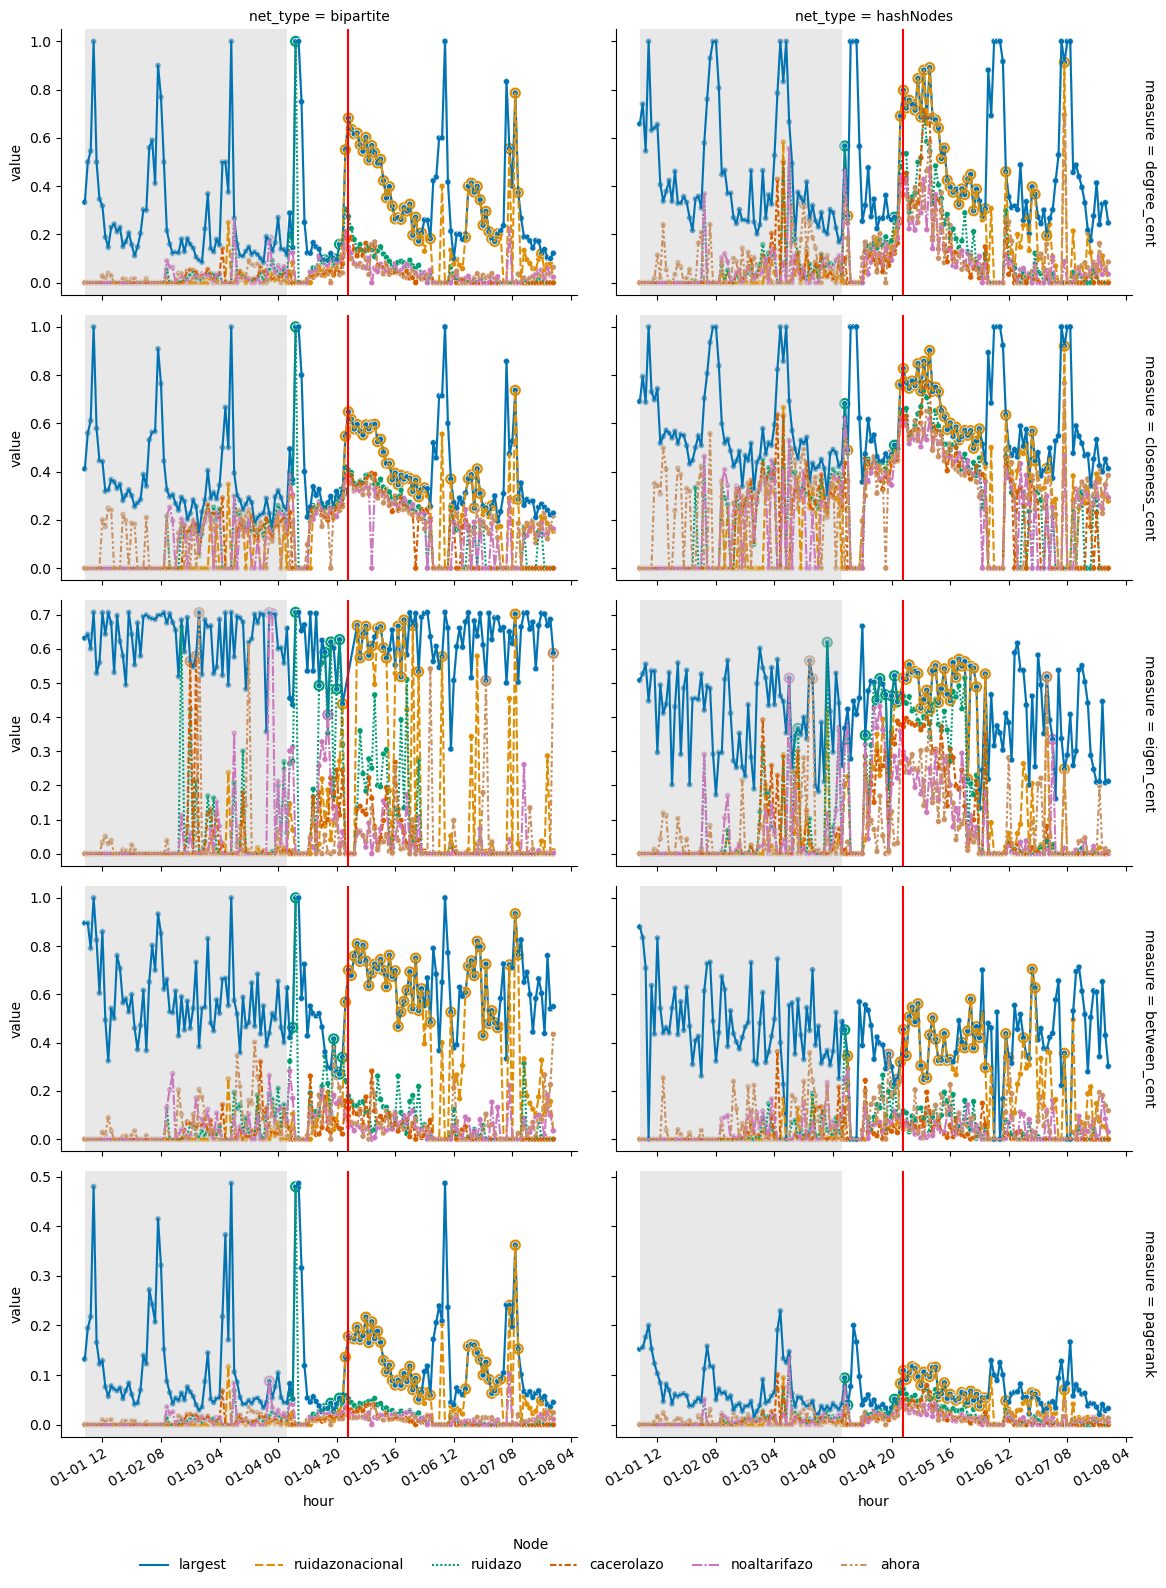

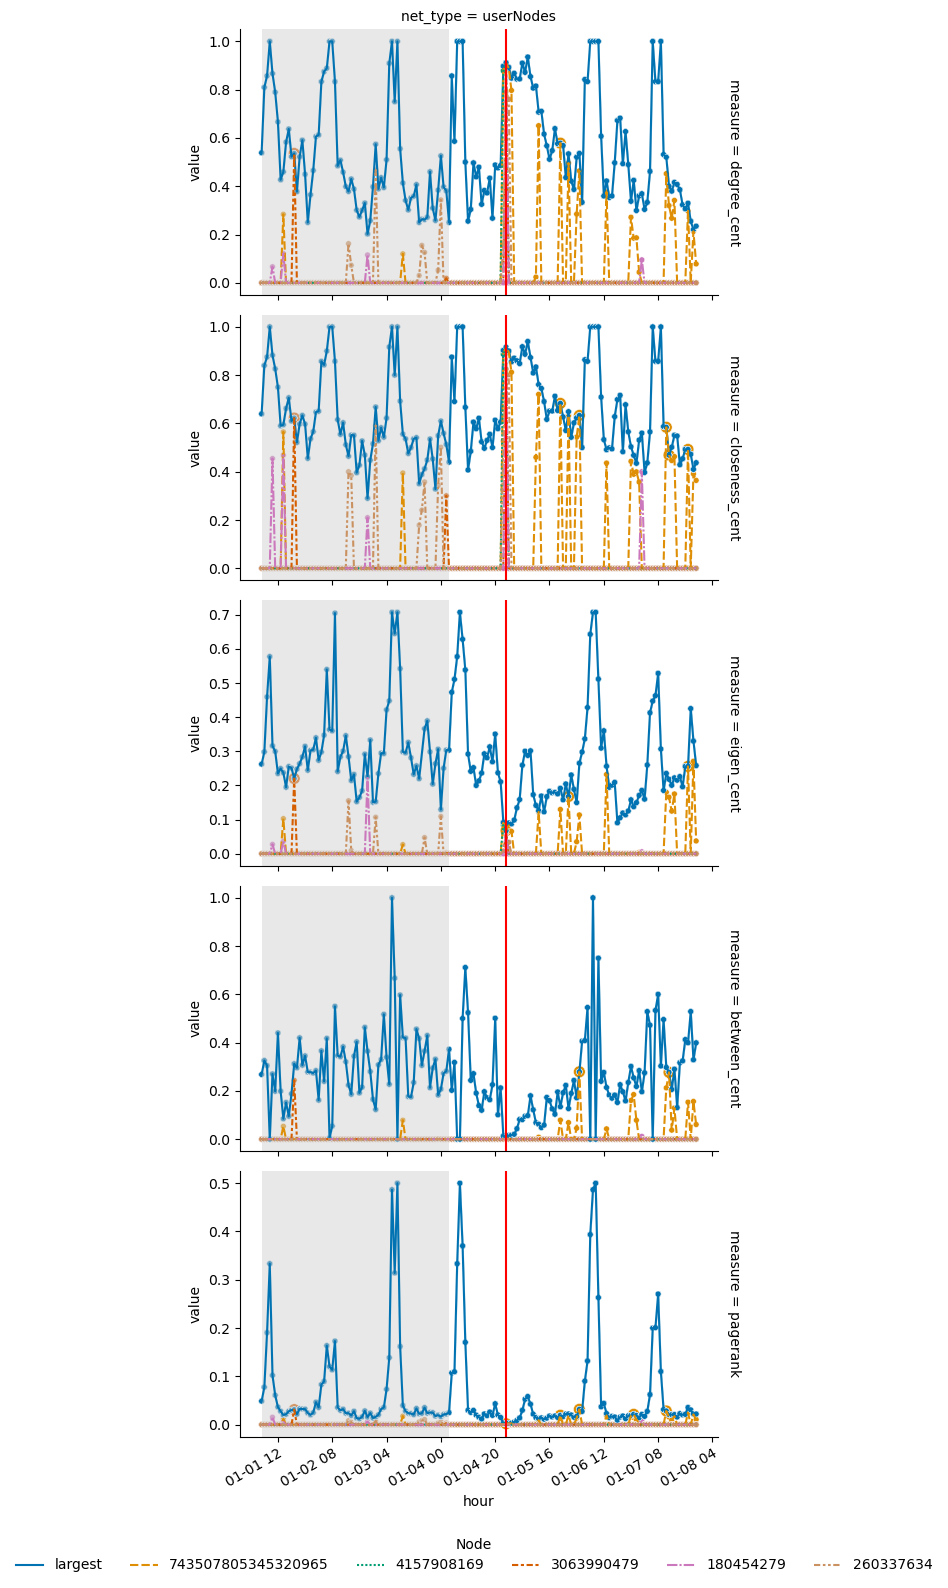

In [34]:
db = 'noAlt'

freq_hour_df = centrality_measures_df[(centrality_measures_df.db == db) & 
                            (centrality_measures_df.measure != 'degree') & #(centrality_measures_df.measure != 'between_cent') &
                            (centrality_measures_df.net_type != 'userNodes')].reset_index(drop = True)

hue_order = ['largest'] + [node for node in freq_hour_df.node.unique() if node != 'largest']

# Define shading parameters based on the database
if db == '9n':
    date_cutoff = int(pd.to_datetime('2019-11-09 03:00').timestamp() / 3600)
    highlight_date = int(pd.to_datetime('2019-11-09 21:00').timestamp() / 3600)
elif db == 'noAlt':
    date_cutoff = int(pd.to_datetime('2019-01-04 03:00').timestamp() / 3600)
    highlight_date = int(pd.to_datetime('2019-01-05 00:00').timestamp() / 3600)


# First set of plots
g = sns.FacetGrid(data=freq_hour_df, row='measure', col='net_type', margin_titles=True, aspect=2, sharey='row')
g.map_dataframe(sns.scatterplot, x='hour', y='value', hue='node', hue_order=hue_order, size='size', palette='colorblind', legend=False)
g.map_dataframe(sns.lineplot, x='hour', y='value', hue='node', hue_order=hue_order, style='node', style_order=hue_order, palette='colorblind')
g.add_legend()
sns.move_legend(g, "center", bbox_to_anchor=(0.4, -0.04), ncol=6, title="Node")

# Add vertical and shaded area based on db
for ax in g.axes.flat:
    ax.axvline(x=highlight_date, c='red')  # Vertical highlight line
    ax.axvspan(freq_hour_df['hour'].min(), date_cutoff, facecolor='lightgray', alpha=0.5)  # Shaded area
    
    # Custom x-axis tick labels
    current_labels = ax.get_xticks()
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')

freq_hour_df = centrality_measures_df[(centrality_measures_df.db == db) & 
                            (centrality_measures_df.measure != 'degree') & #(centrality_measures_df.measure != 'between_cent') &
                            (centrality_measures_df.net_type == 'userNodes')].reset_index(drop = True)

hue_order = ['largest'] + [node for node in freq_hour_df.node.unique() if node != 'largest']

# Second set of plots (for 'userNodes')
g = sns.FacetGrid(data=freq_hour_df, row='measure', col='net_type', margin_titles=True, aspect=2, sharey='row')
g.map_dataframe(sns.scatterplot, x='hour', y='value', hue='node', hue_order=hue_order, size='size', palette='colorblind', legend=False)
g.map_dataframe(sns.lineplot, x='hour', y='value', hue='node', hue_order=hue_order, style='node', style_order=hue_order, palette='colorblind')
g.add_legend()
sns.move_legend(g, "center", bbox_to_anchor=(0.4, -0.04), ncol=6, title="Node")

# Add vertical and shaded area based on db for userNodes plots
for ax in g.axes.flat:
    ax.axvline(x=highlight_date, c='red')  # Vertical highlight line
    ax.axvspan(freq_hour_df['hour'].min(), date_cutoff, facecolor='lightgray', alpha=0.5)  # Shaded area
    
    # Custom x-axis tick labels
    current_labels = ax.get_xticks()
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')


# Pagerank

In [12]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['date'] =pd.to_datetime( node_freq_df.hour * 3600, unit='s').dt.strftime('%m-%d %H')



print(node_freq_df.dtypes)
node_freq_df.tail()

node_type         string[python]
node                      object
freq                       Int64
db                string[python]
hour                       int32
hash_comp                  Int64
hash_comp_size             Int64
user_comp                  Int64
user_comp_size             Int64
bip_comp                   Int64
bip_comp_size              Int64
date                      object
dtype: object


node_type                     node  freq     db    hour  hash_comp  \
628   hashtag            lavagadecabal     1  noAlt  429790         12   
629      user                258925451     1  noAlt  429790       <NA>   
630      user                256188370     1  noAlt  429790       <NA>   
631   hashtag              leninmoreno     1  noAlt  429790       <NA>   
632   hashtag  100diasparaadoctrinarse     1  noAlt  429790         19   

     hash_comp_size  user_comp  user_comp_size  bip_comp  bip_comp_size  \
628               5       <NA>            <NA>        13              6   
629            <NA>       <NA>            <NA>        80              2   
630            <NA>         18               2        29              3   
631            <NA>       <NA>            <NA>        79              2   
632               2       <NA>            <NA>        41              3   

         date  
628  01-11 22  
629  01-11 22  
630  01-11 22  
631  01-11 22  
632  01-11 22

In [24]:
comp_metrics['9n']['436984']['closeness_cent']

{1001215412162433024: 0.46340863200403837,
 303923952: 0.44209341383690204,
 1190492803366838272: 0.4552786560039675,
 180814842: 0.4417171641229983,
 160022979: 0.4080327577394049,
 1121082371774853120: 0.4470436415542834,
 43939236: 0.506853191254417,
 395868299: 0.4436048443115581,
 2985597903: 0.4593076706588699,
 1066455699943841799: 0.5000170210448198,
 1161949963854798850: 0.4080327577394049,
 853736250: 0.44209341383690204,
 4318698732: 0.42162280084851583,
 137570461: 0.5334200080622024,
 121857577: 0.4417171641229983,
 1149789929792311297: 0.4451266448066235,
 846517759: 0.48057191467085464,
 133002462: 0.4083537905936452,
 4228613118: 0.4417171641229983,
 420353139: 0.4675834845446153,
 152369649: 0.4080327577394049,
 811024257010569217: 0.4417171641229983,
 198210589: 0.4417171641229983,
 366333086: 0.4417171641229983,
 203675357: 0.4417171641229983,
 1181572724927451136: 0.446658922413531,
 892533660683038724: 0.46012204596145656,
 780834011203538944: 0.555693434523044,
 5

In [ ]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['date'] =pd.to_datetime( node_freq_df.hour * 3600, unit='s').dt.strftime('%m-%d %H')



print(node_freq_df.dtypes)
node_freq_df.tail()

def get_pagerank(comp_metrics, db, reference_nodes, net_type):
    PageRanks = []
    for hour in comp_metrics[db].keys(): 
        for key in reference_nodes.keys():
            try:
                pr = comp_metrics[db][hour]['pagerank'][key]
            except KeyError:
                pr = 0 
            

            PageRanks.append([db, hour, net_type, key, 'pagerank', pr])
            
    return PageRanks


def get_key_with_largest_value(dic):
    my_dict = dic
    # Sorting the dictionary by its values
    sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
    key = list(sorted_dict.keys())[0]
    value = sorted_dict[key]
    return key, value


def get_largest_pagerank(comp_metrics, db, net_type):
    PageRanks = []
    for hour in comp_metrics[db].keys(): 
        key, pr = get_key_with_largest_value(comp_metrics[db][hour]['pagerank'])
        largest_cent.append([db, hour, net_type, key, 'degree', pr])
            

        PageRanks.append([db, hour, net_type, key, 'pagerank', pr])
            
    return PageRanks

kcores = []

for net_type in ['bipartite', 'hashNodes', 'userNodes']:

    # def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_comp'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'hash_comp'
    else:
        nodes = ['user']
        comp_col = 'user_comp'
        
    comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/pageRank_kCore_{}.pickle'.format(net_type)

    with open(comp_metrics_path, 'rb') as handle:
        comp_metrics = pickle.load(handle)

    n_top_nodes = 5


    for db in ['9n', 'noAlt']:

        hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

        reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                                    (node_freq_df.db == db) &
                                    (node_freq_df.hour == hour), : ].sort_values('freq', 
                                                    ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

        reference_nodes = {y: x for x, y in reference_nodes_dec.items()}

        kcores += get_pagerank(comp_metrics, db, reference_nodes, net_type)

PageRanks_df = pd.DataFrame(kcores, columns=['db', 'hour', 'net_type', 'node', 'measure', 'value'])

PageRanks_df.hour = PageRanks_df.hour.astype(int)
PageRanks_df = PageRanks_df[((PageRanks_df.db == '9n') & 
                    (PageRanks_df.hour <= 437059) & 
                    (PageRanks_df.hour >= 436998)) |
              ((PageRanks_df.db != '9n') & 
                    (PageRanks_df.hour >= 429534) & 
                    (PageRanks_df.hour <= 429694)) ].reset_index(drop = True)

PageRanks_df

node_type         string[python]
node                      object
freq                       Int64
db                string[python]
hour                       int32
hash_comp                  Int64
hash_comp_size             Int64
user_comp                  Int64
user_comp_size             Int64
bip_comp                   Int64
bip_comp_size              Int64
date                      object
dtype: object


db    hour   net_type                       node   measure     value
0        9n  436998  bipartite  9ngranmarchaporlajusticia  pagerank  0.035311
1        9n  436998  bipartite               9njusticiaya  pagerank  0.025881
2        9n  436998  bipartite                 9njusticia  pagerank  0.017994
3        9n  436998  bipartite                    bolivia  pagerank  0.012910
4        9n  436998  bipartite                    9nyovoy  pagerank  0.009319
...     ...     ...        ...                        ...       ...       ...
3340  noAlt  429694  userNodes         743507805345320965  pagerank  0.007307
3341  noAlt  429694  userNodes                 4157908169  pagerank  0.000000
3342  noAlt  429694  userNodes                 3063990479  pagerank  0.000000
3343  noAlt  429694  userNodes                  180454279  pagerank  0.000000
3344  noAlt  429694  userNodes                  260337634  pagerank  0.000000

[3345 rows x 6 columns]

In [14]:
# Combine centrality_measures_df and PageRanks_df, ensuring that size values for PageRank match the other centrality measures
# based on net_type, node, hour, and db.

# First, merge the PageRanks_df with centrality_measures_df on the keys to get the correct 'size' values for PageRank entries.
combined_df = pd.concat([centrality_measures_df, PageRanks_df], ignore_index=True)

# Fill in 'size' for PageRank entries where 'measure' is 'pagerank' by matching values from the centrality measures based on relevant columns.
combined_df['size'] = combined_df.groupby(['db', 'hour', 'net_type', 'node'])['size'].transform(lambda x: x.ffill().bfill())

# Ensure the final DataFrame has the same structure as centrality_measures_df
combined_df = combined_df[centrality_measures_df.columns]

combined_df

db    hour   net_type                       node         measure  \
0         9n  436998  bipartite  9ngranmarchaporlajusticia          degree   
1         9n  436998  bipartite  9ngranmarchaporlajusticia     degree_cent   
2         9n  436998  bipartite  9ngranmarchaporlajusticia  closeness_cent   
3         9n  436998  bipartite  9ngranmarchaporlajusticia      eigen_cent   
4         9n  436998  bipartite  9ngranmarchaporlajusticia    between_cent   
...      ...     ...        ...                        ...             ...   
35995  noAlt  429694  userNodes         743507805345320965        pagerank   
35996  noAlt  429694  userNodes                 4157908169        pagerank   
35997  noAlt  429694  userNodes                 3063990479        pagerank   
35998  noAlt  429694  userNodes                  180454279        pagerank   
35999  noAlt  429694  userNodes                  260337634        pagerank   

           value  size  
0      18.000000   1.0  
1       0.114650   1.0  
2       0.300378   1.0  
3       0.040509   1.0  
4       0.000000   1.0  
...          ...   ...  
35995   0.007307   1.0  
35996   0.000000   1.0  
35997   0.000000   1.0  
35998   0.000000   1.0  
35999   0.000000   1.0  

[36000 rows x 7 columns]

C:\Users\neuro\AppData\Local\Temp\ipykernel_8036\445796422.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right', rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_8036\445796422.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right', rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_8036\445796422.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right', rotation_mode = 'anchor')


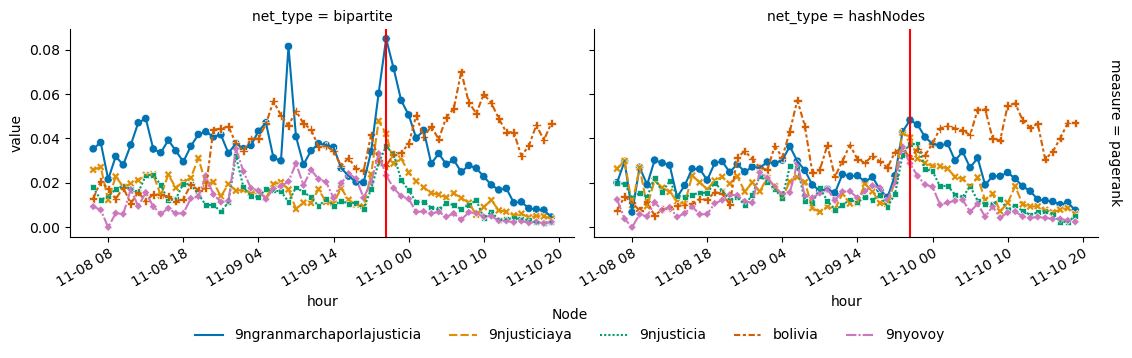

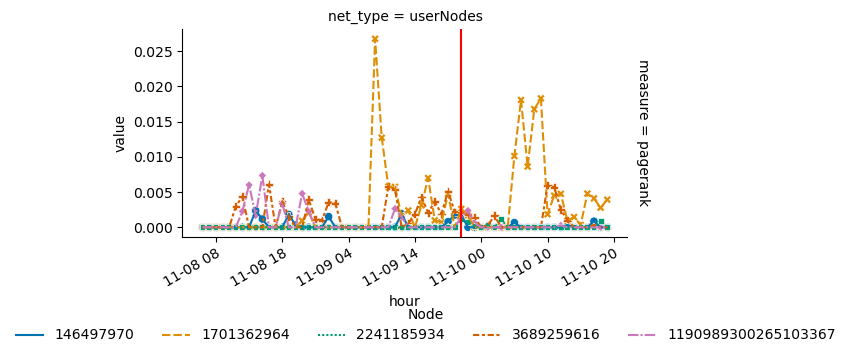

In [38]:
db = '9n'
# db = 'noAlt'

freq_hour_df = PageRanks_df[(PageRanks_df.db == db) & 
                            (PageRanks_df.measure != 'degree') & #(PageRanks_df.measure != 'between_cent') &
                            (PageRanks_df.net_type != 'userNodes')].reset_index(drop = True)

g = sns.FacetGrid(data = freq_hour_df, row = 'measure', col = 'net_type', margin_titles=True, aspect=2, sharey='row', )

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'value', 
                hue = 'node', style = 'node', palette = 'colorblind')

g.map_dataframe(sns.lineplot, x = 'hour', y = 'value', 
                hue = 'node', style = 'node', palette = 'colorblind')

g.add_legend()

sns.move_legend(g, "center", bbox_to_anchor=(0.4, -.1), ncol=5, title="Node")

if db == '9n':
    g.map(plt.axvline, x = 437037, c = 'r')
else:
    g.map(plt.axvline, x = 429624, c = 'r')


for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right', rotation_mode = 'anchor')

freq_hour_df = PageRanks_df[(PageRanks_df.db == db) & 
                            (PageRanks_df.measure != 'degree') & #(PageRanks_df.measure != 'between_cent') &
                            (PageRanks_df.net_type == 'userNodes')].reset_index(drop = True)

g = sns.FacetGrid(data = freq_hour_df, row = 'measure', col = 'net_type', margin_titles=True, aspect=2, sharey='row', )

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'value', 
                hue = 'node', style = 'node', palette = 'colorblind')

g.map_dataframe(sns.lineplot, x = 'hour', y = 'value', 
                hue = 'node', style = 'node', palette = 'colorblind')

g.add_legend()

sns.move_legend(g, "center", bbox_to_anchor=(0.4, -.1), ncol=5, title="Node")

if db == '9n':
    g.map(plt.axvline, x = 437037, c = 'r')
else:
    g.map(plt.axvline, x = 429624, c = 'r')


for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right', rotation_mode = 'anchor')



# K-core

In [7]:
kCore_path = 'D:/FV/Personal/VIU/clean_data/kCore_connectivity.pickle'

try:
    with open(kCore_path, 'rb') as handle:
        kCore = pickle.load(handle)
except:
    def get_kcore(comp_metrics, db, net_type):
        kcores = []
        for hour in tqdm(comp_metrics[db].keys(), desc='Processing {} {} network'.format(db, net_type)): 
            G = comp_metrics[db][hour]['kcore']

            node_size = len(list(G.nodes))
            edge_size = len(list(G.edges))
            edge_conncetivity = nx.edge_connectivity(G)
            node_connectiviy = nx.node_connectivity(G)
                
            kcores.append([db, hour, net_type,node_size , edge_size, node_connectiviy, edge_conncetivity])
                
        return kcores

    kCore = []

    for net_type in ['bipartite', 'hashNodes', 'userNodes']:

        # def plot_Node_freq():
        pd.set_option('future.no_silent_downcasting', True)
        if 'bipartite' in net_type:
            nodes = ['hashtag', 'user']
            comp_col = 'bip_comp'
        elif net_type == 'hashNodes':
            nodes = ['hashtag']
            comp_col = 'hash_comp'
        else:
            nodes = ['user']
            comp_col = 'user_comp'
            
        comp_metrics_path = 'D:/FV/Personal/VIU/clean_data/pageRank_kCore_{}.pickle'.format(net_type)

        with open(comp_metrics_path, 'rb') as handle:
            comp_metrics = pickle.load(handle)

        n_top_nodes = 5


        for db in ['9n', 'noAlt']:

            kCore += get_kcore(comp_metrics, db, net_type)

    with open('D:/FV/Personal/VIU/clean_data/kCore_connectivity.pickle', 'wb') as handle:
        pickle.dump(kCore, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
dates.hour.tolist()

[437001,
 437002,
 437003,
 437004,
 437005,
 437006,
 437007,
 437008,
 437009,
 437010,
 437011,
 437012,
 437013,
 437014,
 437015,
 437016,
 437017,
 437018,
 437019,
 437020,
 437021,
 437025,
 437026,
 437027,
 437028,
 437029,
 437030,
 437031,
 437032,
 437033,
 437034,
 437035,
 437036,
 437037,
 437038,
 437039,
 437040,
 437041,
 437042,
 437043,
 437044,
 437045,
 437046,
 437049,
 437050,
 437051,
 437052,
 437053,
 437054,
 437055,
 437056,
 437057,
 437058,
 437059,
 429542,
 429543,
 429551,
 429552,
 429565,
 429566,
 429567,
 429568,
 429569,
 429570,
 429571,
 429572,
 429573,
 429574,
 429575,
 429576,
 429577,
 429578,
 429589,
 429590,
 429591,
 429592,
 429593,
 429594,
 429595,
 429596,
 429597,
 429598,
 429599,
 429600,
 429601,
 429602,
 429611,
 429612,
 429613,
 429614,
 429615,
 429616,
 429617,
 429618,
 429619,
 429620,
 429621,
 429622,
 429623,
 429624,
 429625,
 429626,
 429627,
 429628,
 429629,
 429635,
 429636,
 429637,
 429638,
 429639,
 429640,
 

In [17]:
kCore_df.hour

0       436984
1       436985
2       436986
3       436987
4       436988
         ...  
1066    429786
1067    429787
1068    429788
1069    429789
1070    429790
Name: hour, Length: 1071, dtype: object

In [37]:
kCore_df = pd.DataFrame(kCore, columns = ['db', 'hour', 'net_type', 'node_size', 'edge_size', 'node_connectivity', 'edge_connectivity'])
kCore_df['hour'] = kCore_df.hour.astype(int)

cols = ['node_size', 'node_connectivity']

df = kCore_df[kCore_df.hour.isin(dates.hour.tolist())].reset_index(drop = True)

df_long = df.melt(id_vars=['db', 'hour', 'net_type',], value_vars=cols, )

In [40]:
kCore_df = pd.DataFrame(kCore, columns = ['db', 'hour', 'net_type', 'node_size', 'edge_size', 'node_connectivity', 'edge_connectivity'])
kCore_df['hour'] = kCore_df.hour.astype(int)

cols = ['edge_size', 'edge_connectivity']
2
df = kCore_df[kCore_df.hour.isin(dates.hour.tolist())].reset_index(drop = True)

df_long = df.melt(id_vars=['db', 'hour', 'net_type',], value_vars=cols, )

C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\2766189180.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\2766189180.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\2766189180.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\2766189180.py:31: UserWarning: set_ticklabels() should only be used with a fixed

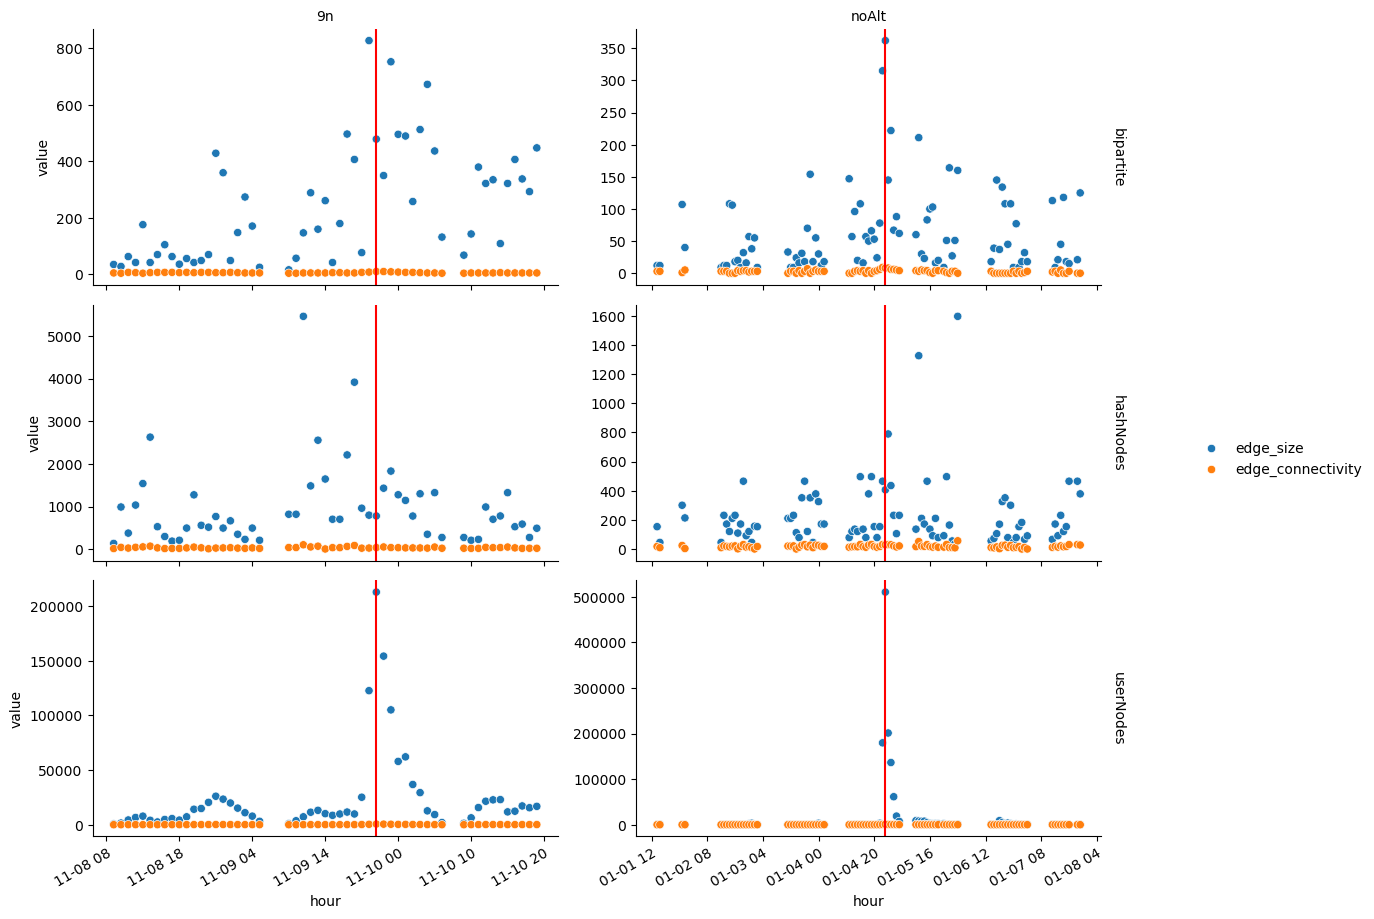

In [41]:


g = sns.FacetGrid(data=df_long,
                col = 'db', row = 'net_type', 
                sharex='col', sharey = False, 
                aspect = 2, margin_titles=True)

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'value', hue = 'variable')
# g.map_dataframe(sns.lineplot, x = 'hour', y = 'value', hue = 'variable')

g.set_titles(col_template='{col_name}', row_template='{row_name}')

def add_vline(data, **kwargs):
    db_value = data['db'].iloc[0]
    if db_value == '9n':
        plt.axvline(x=437037, c='r')
    else:
        plt.axvline(x=429624, c='r')

g.add_legend()
        
# Add the vertical lines using the custom function
g.map_dataframe(add_vline)

for ax in g.axes.flat:
    # # Set y-axis to log scale
    # ax.set_yscale('log')
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')




C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\573365171.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\573365171.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\573365171.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_23576\573365171.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. af

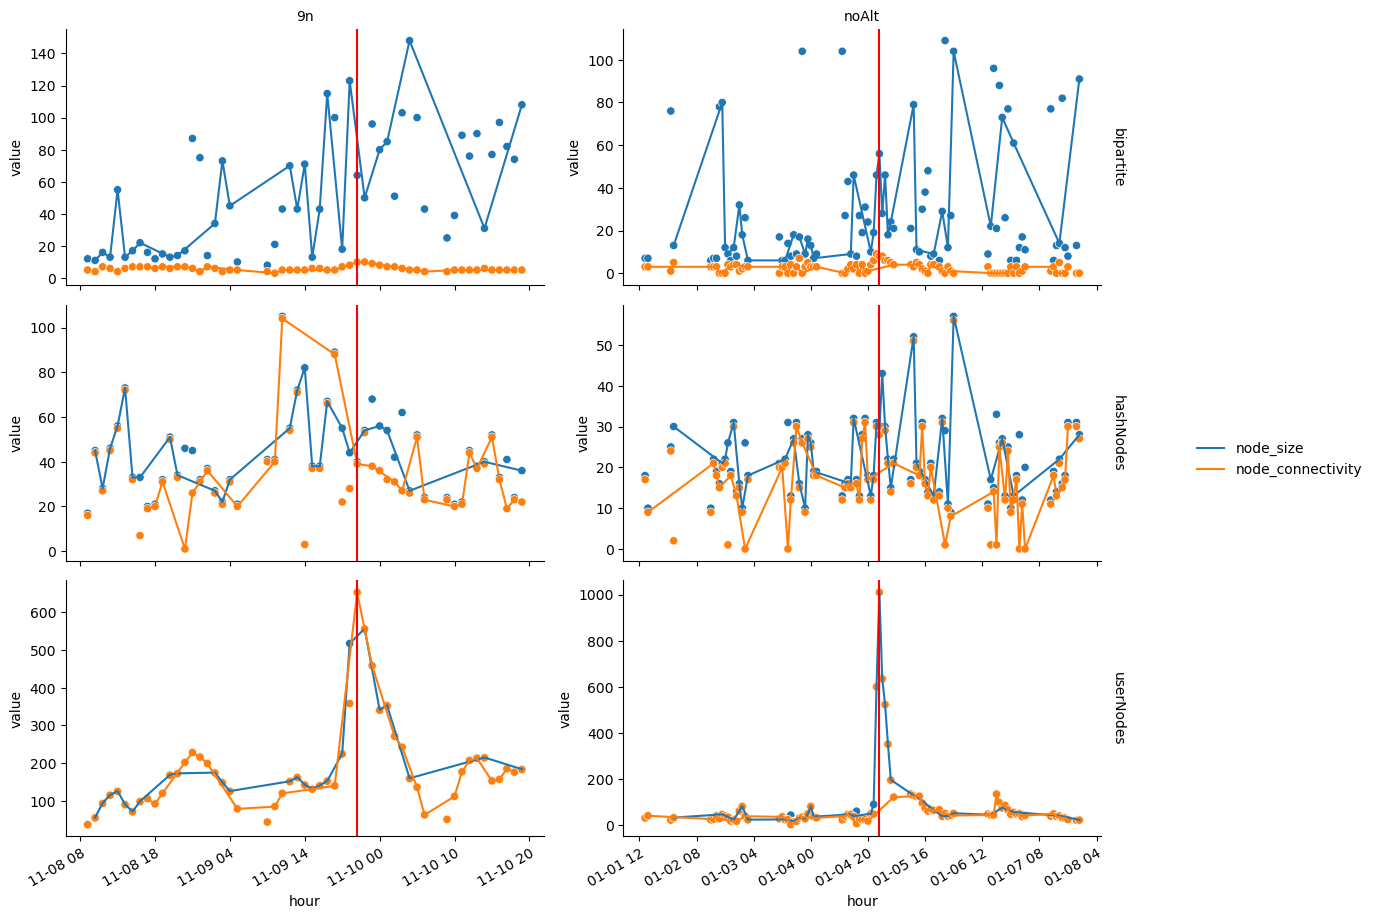

In [31]:
g = sns.FacetGrid(data=df_long,
                col='db', row='net_type', 
                sharex='col', sharey=False, 
                aspect=2, margin_titles=True)

# Scatterplot first
g.map_dataframe(sns.scatterplot, x='hour', y='value', hue='variable')

# Now map the lineplot, ensuring it doesn't connect non-consecutive points
def plot_line(data, **kwargs):
    # Sort data by 'hour' if not already sorted
    data = data.sort_values(by='hour')
    
    # Identify non-consecutive points
    consecutive = data['hour'].diff().fillna(0) == 1
    
    # Where the points are non-consecutive, introduce NaNs to break the line
    data.loc[~consecutive, 'value'] = np.nan
    
    # Now plot the lineplot
    sns.lineplot(data=data, x='hour', y='value', hue='variable', **kwargs)

g.map_dataframe(plot_line)

g.set_titles(col_template='{col_name}', row_template='{row_name}')

def add_vline(data, **kwargs):
    db_value = data['db'].iloc[0]
    if db_value == '9n':
        plt.axvline(x=437037, c='r')
    else:
        plt.axvline(x=429624, c='r')

g.add_legend()

# Add the vertical lines using the custom function
g.map_dataframe(add_vline)

for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation=30, ha='right', rotation_mode='anchor')


# Log Log plots

In [4]:

def plot_PDF_and_CCDF(freq_hour_df, title = None):
    # Calculate the frequency of frequencies
    frequency_counts = freq_hour_df['freq'].value_counts().sort_index()

    # Calculate the cumulative distribution function (CDF)
    cumulative_counts = frequency_counts.cumsum()
    total_counts = cumulative_counts.iloc[-1]
    cdf = cumulative_counts / total_counts

    # Calculate the complementary cumulative distribution function (CCDF)
    ccdf = 1 - cdf

    # Prepare data for plotting
    ccdf_plot_data = pd.DataFrame({
        'frequency': frequency_counts.index,
        'ccdf': ccdf.values
    })

    # Calculate the fraction of hashtags for each frequency
    fraction_of_hashtags = frequency_counts / len(freq_hour_df)

    # Prepare data for inset plotting
    fraction_plot_data = pd.DataFrame({
        'frequency': frequency_counts.index,
        'fraction': fraction_of_hashtags.values
    })

    # Create the main log-log scatter plot (CCDF)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='frequency', y='fraction', data=fraction_plot_data, ax= ax)
    ax.set(xscale='log', yscale='log')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Fraction')
    ax.set_title(title)
    ax.grid(True)

    # Create the inset log-log scatter plot (Frequency Probability by Frequency)
    ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=1)
    sns.scatterplot(x='frequency', y='ccdf', data=ccdf_plot_data, ax=ax_inset)
    ax_inset.set(xscale='log', yscale='log')
    ax_inset.set_xlabel('Frequency')
    ax_inset.set_ylabel('CCDF')
    ax_inset.grid(True)

    plt.show()

In [49]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'
# node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour_nodeFreqLargerThan2.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df

node_type                       node  freq     db    hour  hash_community  \
0     hashtag                    bolivia   171     9n  436984               4   
1     hashtag  9ngranmarchaporlajusticia   116     9n  436984               4   
2     hashtag            lacuevadeofelia    82     9n  436984               3   
3     hashtag         cambiosparasiempre    82     9n  436984               4   
4     hashtag                 buenjueves    63     9n  436984               2   
..        ...                        ...   ...    ...     ...             ...   
628   hashtag              lavagadecabal     1  noAlt  429790            <NA>   
629      user                  258925451     1  noAlt  429790            <NA>   
630      user                  256188370     1  noAlt  429790            <NA>   
631   hashtag                leninmoreno     1  noAlt  429790            <NA>   
632   hashtag    100diasparaadoctrinarse     1  noAlt  429790            <NA>   

     hash_community_size  user_community  user_community_size  bip_community  \
0                     39            <NA>                 <NA>              4   
1                     39            <NA>                 <NA>              5   
2                     14            <NA>                 <NA>              1   
3                     39            <NA>                 <NA>             11   
4                     11            <NA>                 <NA>              2   
..                   ...             ...                  ...            ...   
628                 <NA>            <NA>                 <NA>           <NA>   
629                 <NA>            <NA>                 <NA>           <NA>   
630                 <NA>            <NA>                 <NA>           <NA>   
631                 <NA>            <NA>                 <NA>           <NA>   
632                 <NA>            <NA>                 <NA>           <NA>   

     bip_community_size  
0                    22  
1                    36  
2                    38  
3                    24  
4                    25  
..                  ...  
628                <NA>  
629                <NA>  
630                <NA>  
631                <NA>  
632                <NA>  

[257903 rows x 11 columns]

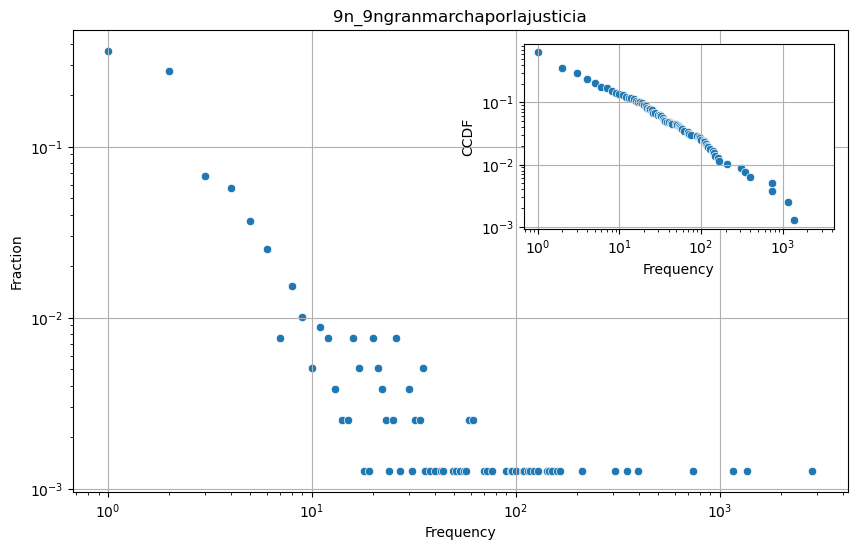

In [7]:
hour_df = node_freq_df[(node_freq_df.db == '9n') &
                  (node_freq_df.hour == 437037) & 
                  (node_freq_df.node_type == 'hashtag')].reset_index(drop = True)

plot_PDF_and_CCDF(hour_df, title = '9n_9ngranmarchaporlajusticia')

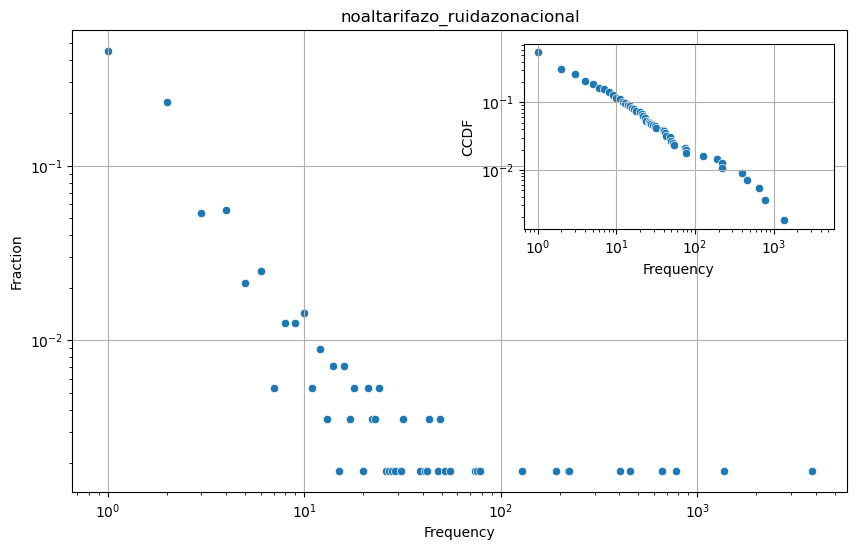

In [8]:

critical_no_df = node_freq_df[(node_freq_df.db == 'noAlt') &
                  (node_freq_df.hour == 429624) & 
                  (node_freq_df.node_type == 'hashtag')].reset_index(drop = True)



plot_PDF_and_CCDF(critical_no_df, title = 'noaltarifazo_ruidazonacional')



# Cluster-size Entropy

In [9]:
def cluster_size_loglog_plot(hour_df, title):
    final_df = pd.DataFrame()
    for col in ['hash_community_size', 'user_community_size', 'bip_community_size']:
        tmp = hour_df.groupby(col).freq.sum().reset_index()
        # Calculate the cumulative distribution function (CDF)
        cumulative_counts = tmp.freq.cumsum()
        total_counts = cumulative_counts.iloc[-1]
        tmp['ccdf'] = 1 - cumulative_counts / total_counts

        tmp['fraction'] = tmp['freq']/tmp['freq'].sum()
        tmp['net_type'] = col.split('_')[0]
        tmp = tmp.rename(columns={col:'cluseter size'})

        final_df = pd.concat([final_df, tmp])

    # Create the main log-log scatter plot (CCDF)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='cluseter size', y='fraction', hue='net_type', data=final_df, ax= ax,legend=False)
    ax.set(xscale='log', yscale='log')
    ax.set_xlabel('Cluseter size')
    ax.set_ylabel('Fraction')
    ax.set_title(title)
    ax.grid(True)

    # Create the inset log-log scatter plot (Frequency Probability by Frequency)
    ax_inset = inset_axes(ax, width="40%", height="40%", loc='lower right', borderpad=1)
    sns.scatterplot(x='cluseter size', y='ccdf', hue='net_type', data=final_df, ax=ax_inset)
    ax_inset.set(xscale='log', yscale='log')
    ax_inset.set_xlabel('Cluseter size')
    ax_inset.set_ylabel('CCDF')
    ax_inset.grid(True)

    plt.show()

In [10]:


def get_cluster_size_entropy_from_frequency(freq_hour_df):

    # Calculate the frequency of frequencies
    frequency_counts = freq_hour_df['freq'].value_counts().sort_index()

    # Calculate the fraction of hashtags for each frequency
    fraction_of_hashtags = frequency_counts / len(freq_hour_df)

    # Prepare data for inset plotting
    fraction_plot_data = pd.DataFrame({
        'frequency': frequency_counts.index,
        'fraction': fraction_of_hashtags.values
    })

    fraction_plot_data['ent'] = fraction_plot_data.fraction * np.log(fraction_plot_data.fraction)

    cluster_size_entropy = -fraction_plot_data.sum().ent

    return cluster_size_entropy

In [13]:
# node_freq_comm_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour.pickle'
node_freq_comm_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour_nodeFreqLargerThan2.pickle'


with open(node_freq_comm_path, 'rb') as handle:
    node_freq_comm_df = pickle.load(handle).convert_dtypes()

node_freq_comm_df['hour'] = node_freq_comm_df.hour.astype(int)

node_freq_comm_df['date'] =pd.to_datetime( node_freq_comm_df.hour * 3600, unit='s').dt.strftime('%m-%d %H')



print(node_freq_comm_df.dtypes)
node_freq_comm_df.tail()

node_type              string[python]
node                           object
freq                            Int64
db                     string[python]
hour                            int32
hash_community                  Int64
hash_community_size             Int64
user_community                  Int64
user_community_size             Int64
bip_community                   Int64
bip_community_size              Int64
date                           object
dtype: object


node_type                     node  freq     db    hour  hash_community  \
628   hashtag            lavagadecabal     1  noAlt  429790            <NA>   
629      user                258925451     1  noAlt  429790            <NA>   
630      user                256188370     1  noAlt  429790            <NA>   
631   hashtag              leninmoreno     1  noAlt  429790            <NA>   
632   hashtag  100diasparaadoctrinarse     1  noAlt  429790            <NA>   

     hash_community_size  user_community  user_community_size  bip_community  \
628                 <NA>            <NA>                 <NA>           <NA>   
629                 <NA>            <NA>                 <NA>           <NA>   
630                 <NA>            <NA>                 <NA>           <NA>   
631                 <NA>            <NA>                 <NA>           <NA>   
632                 <NA>            <NA>                 <NA>           <NA>   

     bip_community_size      date  
628                <NA>  01-11 22  
629                <NA>  01-11 22  
630                <NA>  01-11 22  
631                <NA>  01-11 22  
632                <NA>  01-11 22

In [14]:
node_freq_comm_df = node_freq_comm_df[node_freq_comm_df.freq > 2]

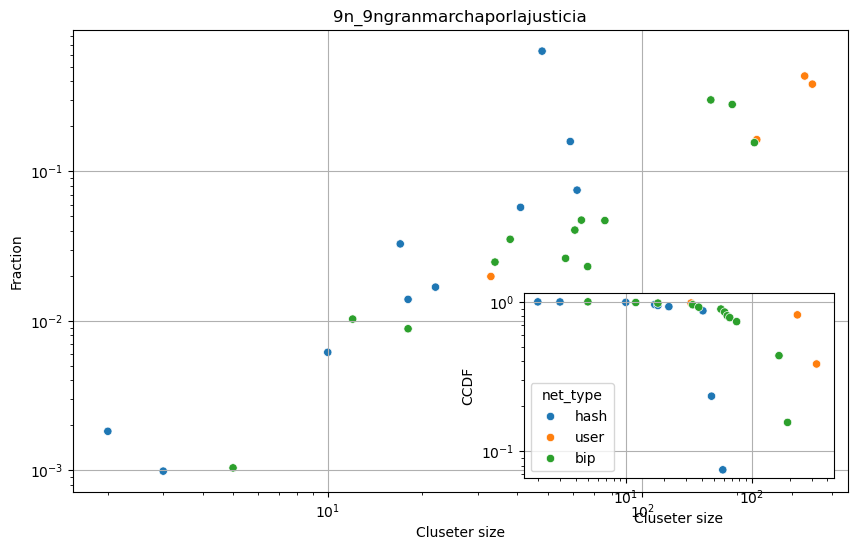

In [15]:
critical_9n_df = node_freq_comm_df[(node_freq_comm_df.db == '9n') &
                  (node_freq_comm_df.hour == 437037)].reset_index(drop = True)

title = '9n_9ngranmarchaporlajusticia'

cluster_size_loglog_plot(critical_9n_df, title)

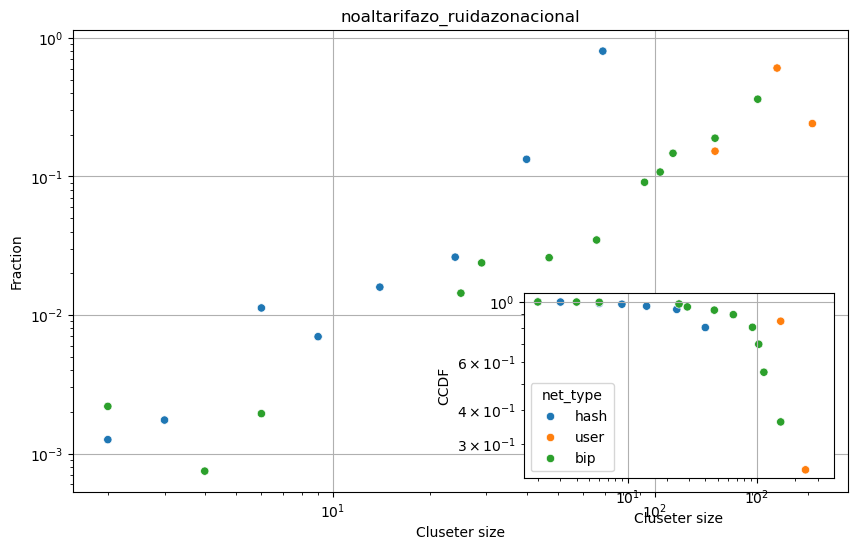

In [16]:

critical_no_df = node_freq_comm_df[(node_freq_comm_df.db == 'noAlt') &
                  (node_freq_comm_df.hour == 429624)].reset_index(drop = True)

title = 'noaltarifazo_ruidazonacional'

cluster_size_loglog_plot(critical_no_df, title)

In [17]:
node_freq_comm_critical_hash_9n_df = node_freq_comm_df[(node_freq_comm_df.db == '9n') &
                  (node_freq_comm_df.hour == 437037) ].reset_index(drop = True)


group = node_freq_comm_critical_hash_9n_df.copy()

def get_clus_entropy(group, col):
    freq = group.groupby('hash_community_size').freq.sum()
    prob_cluster = freq/freq.sum()

    entropy = - np.sum(prob_cluster*np.log(prob_cluster))

    return entropy

In [18]:
def get_clus_entropy(group, col):
    freq = group.groupby(col).freq.sum()
    prob_cluster = freq/freq.sum()

    entropy = - np.sum(prob_cluster*np.log(prob_cluster))

    return entropy



hash_entropy = node_freq_comm_df.groupby(['db', 'hour']).apply(
    lambda group: get_clus_entropy(group, 'hash_community_size')).reset_index()
hash_entropy['net_type'] = 'hashNodes'

user_entropy = node_freq_comm_df.groupby(['db', 'hour']).apply(
    lambda group: get_clus_entropy(group, 'user_community_size')).reset_index()
user_entropy['net_type'] = 'userNodes'

bip_entropy = node_freq_comm_df.groupby(['db', 'hour']).apply(
    lambda group: get_clus_entropy(group, 'bip_community_size')).reset_index()
bip_entropy['net_type'] = 'bipartite'


C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\1993012036.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hash_entropy = node_freq_comm_df.groupby(['db', 'hour']).apply(
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\1993012036.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_entropy = node_freq_comm_df.groupby(['db', 'hour']).apply(
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\1993

C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\458846554.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\458846554.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\458846554.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\458846554.py:47: UserWarning: set_ticklabels() should only be used with a fixed num

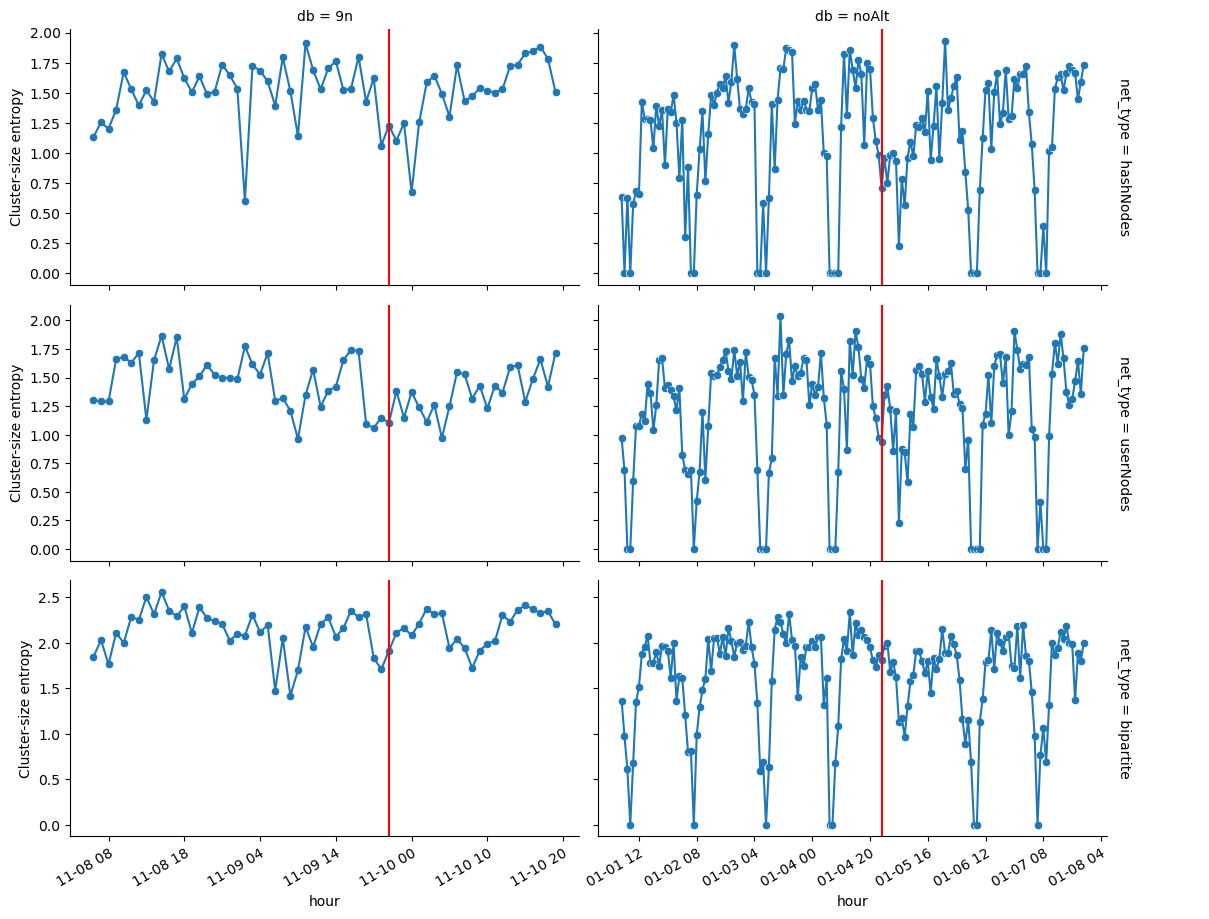

In [19]:
d = {0:'Cluster-size entropy'}
clust_entropy_df = pd.concat([hash_entropy, user_entropy, bip_entropy]).rename(columns=d)

clust_entropy_df['hour'] = clust_entropy_df.hour.astype(int)

clust_entropy_df = clust_entropy_df[((clust_entropy_df.db == '9n') & 
                    (clust_entropy_df.hour <= 437059) & 
                    (clust_entropy_df.hour >= 436998)) |
              ((clust_entropy_df.db != '9n') & 
                    (clust_entropy_df.hour >= 429534) & 
                    (clust_entropy_df.hour <= 429694)) ].reset_index(drop = True)


def add_vline(data, **kwargs):
    db_value = data['db'].iloc[0]
    if db_value == '9n':
        plt.axvline(x=437037, c='r')
    else:
        plt.axvline(x=429624, c='r')


g = sns.FacetGrid(data = clust_entropy_df, row = 'net_type', col = 'db', margin_titles=True, aspect=2, sharey='row', sharex='col')

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'Cluster-size entropy', )

g.map_dataframe(sns.lineplot, x = 'hour', y = 'Cluster-size entropy', )

g.add_legend()


def add_vline(data, **kwargs):
    db_value = data['db'].iloc[0]
    if db_value == '9n':
        plt.axvline(x=437037, c='r')
    else:
        plt.axvline(x=429624, c='r')
        
# Add the vertical lines using the custom function
g.map_dataframe(add_vline)

for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')




C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\944548953.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\944548953.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')


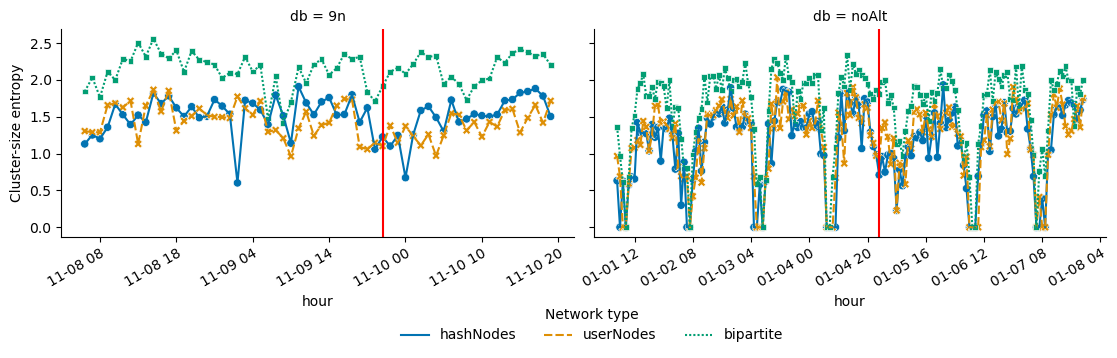

In [20]:
g = sns.FacetGrid(data = clust_entropy_df, col = 'db', margin_titles=True, aspect=2, sharey='row', sharex='col')

g.map_dataframe(sns.scatterplot, x = 'hour', y = 'Cluster-size entropy', 
                hue = 'net_type', style = 'net_type', palette = 'colorblind')

g.map_dataframe(sns.lineplot, x = 'hour', y = 'Cluster-size entropy', 
                hue = 'net_type', style = 'net_type', palette = 'colorblind')

g.add_legend()

sns.move_legend(g, "center", bbox_to_anchor=(0.45, -0.1), ncol=3, title="Network type")

# Add the vertical lines using the custom function
g.map_dataframe(add_vline)

for ax in g.axes.flat:
    # Get the current tick labels
    current_labels = ax.get_xticks()
    # Generate new tick labels based on the current ones
    new_xticklabels = [pd.to_datetime(int(hour) * 3600, unit='s').strftime('%m-%d %H') for hour in current_labels]
    # Set the new tick labels
    ax.set_xticklabels(new_xticklabels, rotation = 30, ha = 'right',  rotation_mode = 'anchor')


In [ ]:
def get_clus_entropy(group, col):
    freq = group.groupby(col).freq.sum()
    prob_cluster = freq/freq.sum()

    entropy = - np.sum(prob_cluster*np.log(prob_cluster))

    return entropy

# Temoporal community detection

In [4]:
from glob import glob
import pickle

str_identifier = 'bipartite'

link_list_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*{}_link_list.pickle'.format(str_identifier)

link_lists = glob(link_list_path)

link_lists

with open(link_lists[0], 'rb') as f:
        link_list = pickle.load(f)

link_list

[(1184163754847682565, 'mmd', 24),
 (1227461558, 'riquelme', 10),
 (1184163754847682565, 'ddm', 10),
 (766428376043286528, 'cambiosparasiempre', 8),
 (1080257890747928576, 'malasuertesdp', 7),
 (1059603446947594240, 'auditoriaaladeudam', 6),
 (828967537207558144, 'elpreciojusto', 6),
 (1187730375285657600, 'auditoriaaladeudam', 6),
 (2510437887, '9ngranmarchaporlajusticia', 6),
 (1167535483515285512, '9ngranmarchaporlajusticia', 6),
 (501188096, 'yase_alrincon', 6),
 (884248666474729472, '7dhastaluegopresidente', 6),
 (884248666474729472, '9ngranmarchaporlajusticia', 6),
 (1270472840, 'auditoriaaladeudam', 6),
 (1058075556414140417, 'auditoriaaladeudam', 5),
 (174788257, 'bienvenidos13', 5),
 (4690204003, 'stornelliaindagatoria', 5),
 (1227461558, 'boca', 5),
 (2884157332, 'fichalimpia', 4),
 (2903191125, 'lacuevadeofelia', 4),
 (1161364358385086464, 'relacionargentinabrasil', 4),
 (154087465, 'elcaosquenosdejan', 4),
 (174489621, 'riquelme', 4),
 (1164687483969396737, 'redessociales',

In [39]:
str_identifier = 'bipartite'
# str_identifier = 'hashNodes'
# str_identifier = 'userNodes'

link_list_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*{}_link_list.pickle'.format(str_identifier)

link_lists = glob(link_list_path)

graphs_9n = {}
graphs_noAlt = {}


for file_path in tqdm(link_lists):
    if '.csv' in file_path:
        continue

    hour = int(file_path.split('_link_list.pickle')[0].split('_')[-2])
    database = file_path.split('\\')[-1].split('_')[0]
    
    with open(file_path, 'rb') as f:
        link_list = pickle.load(f)

    if str_identifier == 'bipartite': # Trimming network
        hash_count = pd.DataFrame(link_list).groupby(1).size()
        hash_only_used_by_one_user = hash_count[hash_count==1].index
        clean_link_list = [link for link in link_list if link[1] not in hash_only_used_by_one_user]
        clean_link_list = [(str(link[0]), str(link[1]), link[2]) for link in clean_link_list]
    else:
        clean_link_list = [tup for tup in link_list if tup[2] != 0]

    clean_link_arr = np.array(clean_link_list)
    nodes = np.concatenate([clean_link_arr[:,0], clean_link_arr[:,1]])

    G = nx.Graph()
    G.add_weighted_edges_from(clean_link_list)

    # get components
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    components = [list(comp) for comp in components]

    G_sub = G.subgraph(components[0])

    # Get database
    if database == '9n':
        graphs_9n[hour] = G
        graphs_9n[hour].name = hour

    elif database == 'no':
        graphs_noAlt[hour] = G
        graphs_noAlt[hour].name = hour
    



100%|██████████| 357/357 [00:02<00:00, 125.59it/s]


In [40]:
def get_temporal_graph(graphs):
    hour_dics = {sorted(list(graphs.keys()))[p]:p for p in range(len(graphs.keys()))}
    for key, value in graphs.items():
        value.name = key
        graphs[key] = value
    tg = tx.from_snapshots({hour_dics[key]:value for key, value in graphs.items()})

    return tg

In [41]:
# Create temporal graph from snapshots.

tg_9n = get_temporal_graph(graphs_9n)
tg_noAlt = get_temporal_graph(graphs_noAlt)

In [29]:
import leidenalg as la

In [42]:
temporal_opts = {}

temporal_membership, improvement = la.find_partition_temporal(
    tg_9n.to_snapshots("igraph"),
    la.ModularityVertexPartition,
    interslice_weight=1.0,
    n_iterations=-1,
    seed=0,
    vertex_id_attr="_nx_name"
)

In [43]:
hours = list(graphs_9n.keys())

tg_comms_df = pd.DataFrame()

for p in range(len(hours)):
    hour = hours[p]
    g = graphs_9n[hours[p]]
    nodes = list(g.nodes())
    node_comm_dic = {}
    for q in range(len(nodes)):
        node_comm_dic[nodes[q]] = temporal_membership[p][q]
    hour_df = pd.DataFrame().from_dict(node_comm_dic, orient='index').reset_index()
    hour_df.columns = ['node', 'tg_com']
    hour_df['hour'] = hour
    tg_comms_df = pd.concat([tg_comms_df, hour_df])

tg_comms_df


node  tg_com    hour
0             1227461558      40  436984
1               riquelme      40  436984
2    1184163754847682565      13  436984
3                    ddm      13  436984
4     766428376043286528      16  436984
..                   ...     ...     ...
587           2213164394       2  437080
588           2330517852       3  437080
589           2356357356       1  437080
590           2394519670       3  437080
591           2440719738      21  437080

[82896 rows x 3 columns]

In [57]:
tg_comms_df.dtypes

node      object
tg_com     int64
hour       int64
dtype: object

In [66]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'
# node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour_nodeFreqLargerThan2.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['node'] = node_freq_df.node.astype(str)

node_freq_df

node_type                       node  freq     db    hour  hash_comp  \
0     hashtag                    bolivia   171     9n  436984          0   
1     hashtag  9ngranmarchaporlajusticia   116     9n  436984          0   
2     hashtag            lacuevadeofelia    82     9n  436984          0   
3     hashtag         cambiosparasiempre    82     9n  436984          0   
4     hashtag                 buenjueves    63     9n  436984          0   
..        ...                        ...   ...    ...     ...        ...   
628   hashtag              lavagadecabal     1  noAlt  429790         12   
629      user                  258925451     1  noAlt  429790       <NA>   
630      user                  256188370     1  noAlt  429790       <NA>   
631   hashtag                leninmoreno     1  noAlt  429790       <NA>   
632   hashtag    100diasparaadoctrinarse     1  noAlt  429790         19   

     hash_comp_size  user_comp  user_comp_size  bip_comp  bip_comp_size  
0               375       <NA>            <NA>         0            918  
1               375       <NA>            <NA>         0            918  
2               375       <NA>            <NA>         0            918  
3               375       <NA>            <NA>         0            918  
4               375       <NA>            <NA>         0            918  
..              ...        ...             ...       ...            ...  
628               5       <NA>            <NA>        13              6  
629            <NA>       <NA>            <NA>        80              2  
630            <NA>         18               2        29              3  
631            <NA>       <NA>            <NA>        79              2  
632               2       <NA>            <NA>        41              3  

[257903 rows x 11 columns]

In [63]:
node_freq_df.node_type.unique()

<StringArray>
['hashtag', 'user']
Length: 2, dtype: string

In [65]:
tg_comms_df['node'] = tg_comms_df.node.astype(str)

In [67]:
node_freq_df = node_freq_df.merge(tg_comms_df, on=['hour', 'node'])

node_freq_df

node_type                       node  freq  db    hour  hash_comp  \
0       hashtag                    bolivia   171  9n  436984          0   
1       hashtag  9ngranmarchaporlajusticia   116  9n  436984          0   
2       hashtag            lacuevadeofelia    82  9n  436984          0   
3       hashtag         cambiosparasiempre    82  9n  436984          0   
4       hashtag                 buenjueves    63  9n  436984          0   
...         ...                        ...   ...  ..     ...        ...   
82891      user                  151546163     1  9n  437080       <NA>   
82892      user                  161057114     1  9n  437080       <NA>   
82893      user                  155207107     1  9n  437080       <NA>   
82894      user                  156636660     1  9n  437080       <NA>   
82895      user                 2806414367     1  9n  437080       <NA>   

       hash_comp_size  user_comp  user_comp_size  bip_comp  bip_comp_size  \
0                 375       <NA>            <NA>         0            918   
1                 375       <NA>            <NA>         0            918   
2                 375       <NA>            <NA>         0            918   
3                 375       <NA>            <NA>         0            918   
4                 375       <NA>            <NA>         0            918   
...               ...        ...             ...       ...            ...   
82891            <NA>          0             442         0            768   
82892            <NA>          0             442         0            768   
82893            <NA>          0             442         0            768   
82894            <NA>          0             442         0            768   
82895            <NA>          0             442         0            768   

       tg_com  
0           1  
1           0  
2          14  
3          16  
4          29  
...       ...  
82891      15  
82892      15  
82893      41  
82894      41  
82895       2  

[82896 rows x 12 columns]

In [68]:
tmp = node_freq_df.groupby(['hour', 'tg_com']).size().reset_index().rename(columns={0:'tg_com_size'})
node_freq_df =  node_freq_df.merge(tmp, on=['hour', 'tg_com'])

In [55]:
node_freq_df.node_type.unique()

<StringArray>
['hashtag']
Length: 1, dtype: string

In [53]:
import matplotlib as mpl

def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_community'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'tg_com'
    else:
        nodes = ['user']
        comp_col = 'user_community'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}



    def get_node_freq_community_per_hour(group):
        group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'tg_com', 'tg_com_size']]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)

    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    # def get_coded_community(group):

    #     coded_community_keys = sorted(group.loc[:, 'order_' + comp_col].unique().tolist())

    #     # if not 0 in coded_community_keys:
    #     #     coded_community_keys = [0] + coded_community_keys
                                
    #     coded_community_dic = {coded_community_keys[p]:p for p in range(len(coded_community_keys))}

    #     coded_community =  group[comp_col].replace(coded_community_dic).astype(object)

    #     return coded_community

    # df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values
    df['comp'] = df['tg_com']

    def create_discrete_palette(cmap_name, num_colors):
        cmap = plt.get_cmap(cmap_name)
        colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
        return colors


    num_colors = df['comp'].nunique()

    palette = create_discrete_palette('jet', num_colors)

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(10, 200), legend=False,
                    palette = 'tab20',
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = '9n'

for net_type in ['userNodes']:
    plot_Node_freq()

C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\1958685072.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')


KeyError: ['user_community']

###### No AL tarifazo

In [86]:
temporal_opts = {}

temporal_membership_noAlt, improvement_noAlt = la.find_partition_temporal(
    tg_noAlt.to_snapshots("igraph"),
    la.ModularityVertexPartition,
    interslice_weight=1.0,
    n_iterations=-1,
    seed=0,
    vertex_id_attr="_nx_name"
)

In [ ]:
import leidenalg as la

In [ ]:
temporal_opts = {}

temporal_membership, improvement = la.find_partition_temporal(
    tg_9n.to_snapshots("igraph"),
    la.ModularityVertexPartition,
    interslice_weight=1.0,
    n_iterations=-1,
    seed=0,
    vertex_id_attr="_nx_name"
)


hours = list(graphs_9n.keys())

tg_comms_df = pd.DataFrame()

for p in range(len(hours)):
    hour = hours[p]
    g = graphs_9n[hours[p]]
    nodes = list(g.nodes())
    node_comm_dic = {}
    for q in range(len(nodes)):
        node_comm_dic[nodes[q]] = temporal_membership[p][q]
    hour_df = pd.DataFrame().from_dict(node_comm_dic, orient='index').reset_index()
    hour_df.columns = ['node', 'tg_com']
    hour_df['hour'] = hour
    tg_comms_df = pd.concat([tg_comms_df, hour_df])

tg_comms_df

node_freq_df = node_freq_df.merge(tg_comms_df, on=['hour', 'node'])


tmp = node_freq_df.groupby(['hour', 'tg_com']).size().reset_index().rename(columns={0:'tg_com_size'})
node_freq_df =  node_freq_df.merge(tmp, on=['hour', 'tg_com'])

C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\2775201919.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
C:\Users\neuro\AppData\Local\Temp\ipykernel_15584\2775201919.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels);


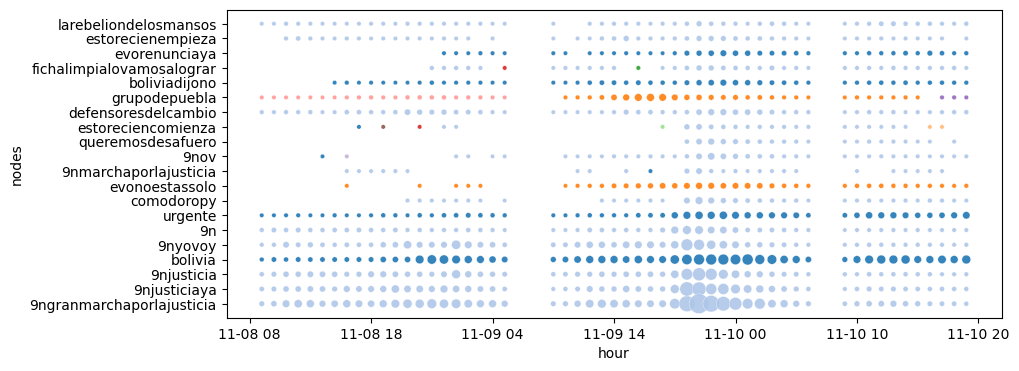

In [ ]:
import matplotlib as mpl

def plot_Node_freq():
    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_community'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'tg_com'
    else:
        nodes = ['user']
        comp_col = 'user_community'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_df.loc[node_freq_df.node_type.isin(nodes) &
                            (node_freq_df.db == db) &
                            (node_freq_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}



    def get_node_freq_community_per_hour(group):
        group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'tg_com', 'tg_com_size']]

    df = node_freq_df.loc[(node_freq_df.db == db) &
                        (node_freq_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)

    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)

    # def get_coded_community(group):

    #     coded_community_keys = sorted(group.loc[:, 'order_' + comp_col].unique().tolist())

    #     # if not 0 in coded_community_keys:
    #     #     coded_community_keys = [0] + coded_community_keys
                                
    #     coded_community_dic = {coded_community_keys[p]:p for p in range(len(coded_community_keys))}

    #     coded_community =  group[comp_col].replace(coded_community_dic).astype(object)

    #     return coded_community

    # df['comp'] = df.groupby('hour').apply(lambda group: get_coded_community(group)).values
    df['comp'] = df['tg_com']

    def create_discrete_palette(cmap_name, num_colors):
        cmap = plt.get_cmap(cmap_name)
        colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
        return colors


    num_colors = df['comp'].nunique()

    palette = create_discrete_palette('jet', num_colors)

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(10, 200), legend=False,
                    palette = 'tab20',
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')


db = '9n'

for net_type in ['hashNodes']:
    plot_Node_freq()